# **CAPSTONE PROJECT** #

## **Industrial safety - NLP based Chatbot** ##

### **Problem Statement:** ###

There is a need for industries/Companies around the globe to undestand why employees still suffer from injuries/accidents in plants. Sometimes they also die in such enviroment. Based on the given description of the incident , it is required to identify the severity of the incident and highlight the saftety risk associated with the incident description.

### **Business Value Proposition:** ###

System which highlights the safety risk associated with the incident.

### **Modeling Objective:** ###

Design  a  ML/DL  based  chatbot  utility  which  can  help  the  professionals  to  highlight  the  safety  risk  as  per  the  incident description.

Considering description as independent variable and Potential accident level as target variable.

### **Data set** ###

### **Source of the data set:** ###
The  database  comes  from one  of  the  biggest  industry  in  Brazil  and  in  the  world.

### **Data set information:** ###
This database is basically records of accidents from 12 different plants in 03 different countries which every line in the data is an occurrence of an accident.

### **Columns description:** ###

**Data:** timestamp or time/date information

**Countries:** which country the accident occurred (anonymised)

**Local:** the city where the manufacturing plant is located (anonymised)

**Industry sector:** which sector the plant belongs to

**Accident level:** from I to VI, it registers how severe was the accident (I means not severe but VI means very severe)

**Potential Accident Level:** Depending on the Accident Level, the database also registers how severe the accident could have been (due to other factors involved in the accident)

**Genre:** if the person is male of female

**Employee or Third Party:** if the injured person is an employee or a third party

**Critical Risk:** some description of the risk involved in the accident

**Description:** Detailed description of how the accident happened.

**Link to download the dataset:** https://www.kaggle.com/ihmstefanini/industrial-safety-and-health-analytics-database

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

!pip install unidecode
import unidecode

!pip install wordcloud
from wordcloud import WordCloud

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import recall_score, precision_score, f1_score

from tensorflow.keras.regularizers import l1, l2, l1_l2
from keras.constraints import unit_norm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



import imblearn
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import pickle

!pip install pyngrok
!pip install numpy==1.26.3
!pip install streamlit==1.29.0
!pip install streamlit-option-menu==0.3.6

import os
from threading import Thread
from pyngrok import ngrok
import pickle
import streamlit as st
from streamlit_option_menu import option_menu


import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data Import And Exploration

In [ ]:
#Importing the data
df = pd.read_excel('/content/drive/My Drive/Data Set - industrial_safety_and_health_database_with_accidents_description.xlsx')

In [ ]:
#Checking the shape
df.shape

(425, 11)

Dataset has 425 records and 11 columns.

In [ ]:
#Checking the info about columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Unnamed: 0                425 non-null    int64         
 1   Data                      425 non-null    datetime64[ns]
 2   Countries                 425 non-null    object        
 3   Local                     425 non-null    object        
 4   Industry Sector           425 non-null    object        
 5   Accident Level            425 non-null    object        
 6   Potential Accident Level  425 non-null    object        
 7   Genre                     425 non-null    object        
 8   Employee or Third Party   425 non-null    object        
 9   Critical Risk             425 non-null    object        
 10  Description               425 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(9)
memory usage: 36.6+ KB


* There is one unnamed column, so we can remove that column.
* All the columns are categorical except Data and Unnamed column.

In [ ]:
#Checking the first 5 records
df.head()

,Unnamed: 0,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
0,0,2016-01-01,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...
1,1,2016-01-02,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...
2,2,2016-01-06,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...
3,3,2016-01-08,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...
4,4,2016-01-10,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...


Data Collection Summary:

1.  There are 425 rows and 11 columns in the dataset

2.  Unnamed:0 column is of numeric type and remaining all the columns are of type object

3.  Categorical columns : Countries, Local, Industry Sector, Accident Level, Potential Accident Level, Genre Employee or Third Party, Critical Risk, Description

4.  Date column: Data

5.  Description is of type text , considered as Input variables or Predictors.

6.  Accident Level or Potential Accident Level considered as target variable.


# Data Cleaning

In [ ]:
#Dropping the Unnamed columns
df = df.drop('Unnamed: 0', axis=1)

In [ ]:
#Checking the duplicate values
df.duplicated().sum()

7

There are 7 duplicate records.

In [ ]:
#Checking the uplicate records
df[df.duplicated() == True]

,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
77,2016-04-01,Country_01,Local_01,Mining,I,V,Male,Third Party (Remote),Others,In circumstances that two workers of the Abrat...
262,2016-12-01,Country_01,Local_03,Mining,I,IV,Male,Employee,Others,During the activity of chuteo of ore in hopper...
303,2017-01-21,Country_02,Local_02,Mining,I,I,Male,Third Party (Remote),Others,Employees engaged in the removal of material f...
345,2017-03-02,Country_03,Local_10,Others,I,I,Male,Third Party,Venomous Animals,On 02/03/17 during the soil sampling in the re...
346,2017-03-02,Country_03,Local_10,Others,I,I,Male,Third Party,Venomous Animals,On 02/03/17 during the soil sampling in the re...
355,2017-03-15,Country_03,Local_10,Others,I,I,Male,Third Party,Venomous Animals,Team of the VMS Project performed soil collect...
397,2017-05-23,Country_01,Local_04,Mining,I,IV,Male,Third Party,Projection of fragments,In moments when the 02 collaborators carried o...


In [ ]:
#Removing the duplicate records
df.drop_duplicates(inplace=True)

In [ ]:
#Renaming the column names
df.rename(columns={'Data' : 'Date', 'Countries':'Country','Genre':'Gender','Employee or Third Party':'Employee Type'},inplace= True)

In [ ]:
#Checking for the missing values
df.isnull().sum()

Date                        0
Country                     0
Local                       0
Industry Sector             0
Accident Level              0
Potential Accident Level    0
Gender                      0
Employee Type               0
Critical Risk               0
Description                 0
dtype: int64

There are no missing values in the dataset.

In [ ]:
#Deriving new columns from Date column - Year, Month, day, Dayname
df['Year'] = df['Date'].apply(lambda x:x.year)
df['Day'] = df['Date'].apply(lambda x:x.day)
df['Month'] = df['Date'].apply(lambda x:x.month)
df['Day_name'] = df['Date'].apply(lambda x:x.day_name())

In [ ]:
df.head()

,Date,Country,Local,Industry Sector,Accident Level,Potential Accident Level,Gender,Employee Type,Critical Risk,Description,Year,Day,Month,Day_name
0,2016-01-01,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,2016,1,1,Friday
1,2016-01-02,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,2016,2,1,Saturday
2,2016-01-06,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,2016,6,1,Wednesday
3,2016-01-08,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...,2016,8,1,Friday
4,2016-01-10,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...,2016,10,1,Sunday


Data Cleansing Summary:

1. Removed UnnamedL 0 column from the dataset
2. Renamed following columns to give meaningfull names
data to Date
Countries to Country
Genre to Gender
Employee or Third Party to Employee type
3. There were 7 duplicate entries , removed them from dataset
4. From Date column, it is observed the accidents entries from 2016-01-01 00:00:00 to 2017-07-09 00:00:00
5. There are 3 country types country_001, country_002, country_003 and highest number of incidents reported in country_001 and lowest incidents are reported in country_003
6. There are 12 local cities where manufacturing plants are located local_01 to local_12 and highest number of accidents are reported in local_03 and lowest number of accidents are reported in local_09 and local_11
7. There are only 3 Inustry Sectors and highest number of accidents are reported from Mining industry sector and lowest number of accidents are reported from others
8.There are only 5 Accident Levels , ranging from lowest severity I to highest severity V and highest number of accidents recorded are of severity Low I and lowest number of accidents recorded are of severity high V.
9. There are only 6 Potential Accident Levels , ranging from lowest severity I to highest severity VI and highest number Potential accidents are reported with severity low I and Lowest number of Potential accidents are reported with severity high VI .
10. There are 2 Genders male and female and highest number of accidents are recorded for male Gender and lowest of accidents are recorded for female gender
11. There are 3 employee types Third Party, Employee and Third Party ( Remote) and highest of accidents are recorded for Third Party and lowest number of accidents are recorded for Third Party (Remote) .
12. There are quite a lot of Critical Risks reported and highest number of accidents are recored of type others Critical Risk .
13. No mising values in the dataset
14. After Data Cleansing, we have now 418 rows and 10 columns

# EXPLORATORY DATA ANALYSIS

Univariate Analysis

<Axes: ylabel='Gender'>

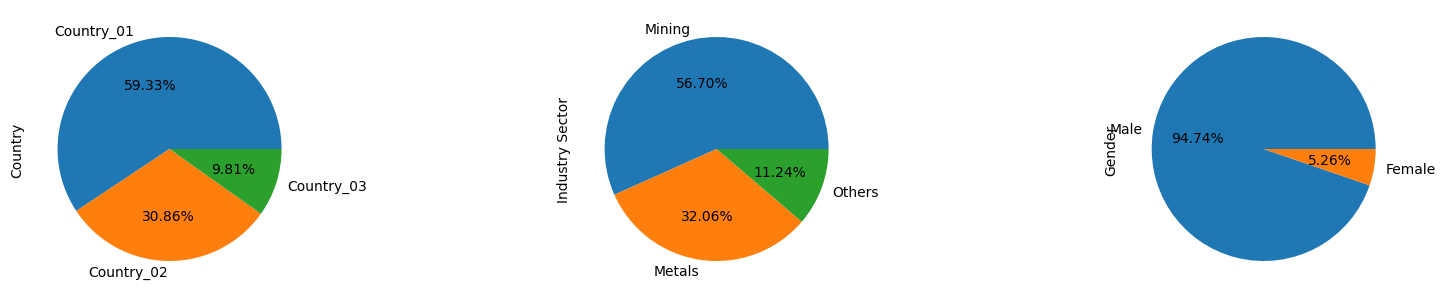

In [ ]:
#Checking the accident distribution in Country, Local and industry sector column
plt.figure(figsize=(20,8))
plt.subplot(2,3,1)
df['Country'].value_counts().plot(kind='pie',autopct='%.2f%%')
plt.subplot(2,3,2)
df['Industry Sector'].value_counts().plot(kind='pie',autopct='%.2f%%')
plt.subplot(2,3,3)
df['Gender'].value_counts().plot(kind='pie',autopct='%.2f%%')

* Majority of the accident happens in Country_01.
* Mining industry has highest accident.
* 94.74% of the accident happens in male.

<Axes: xlabel='Local', ylabel='count'>

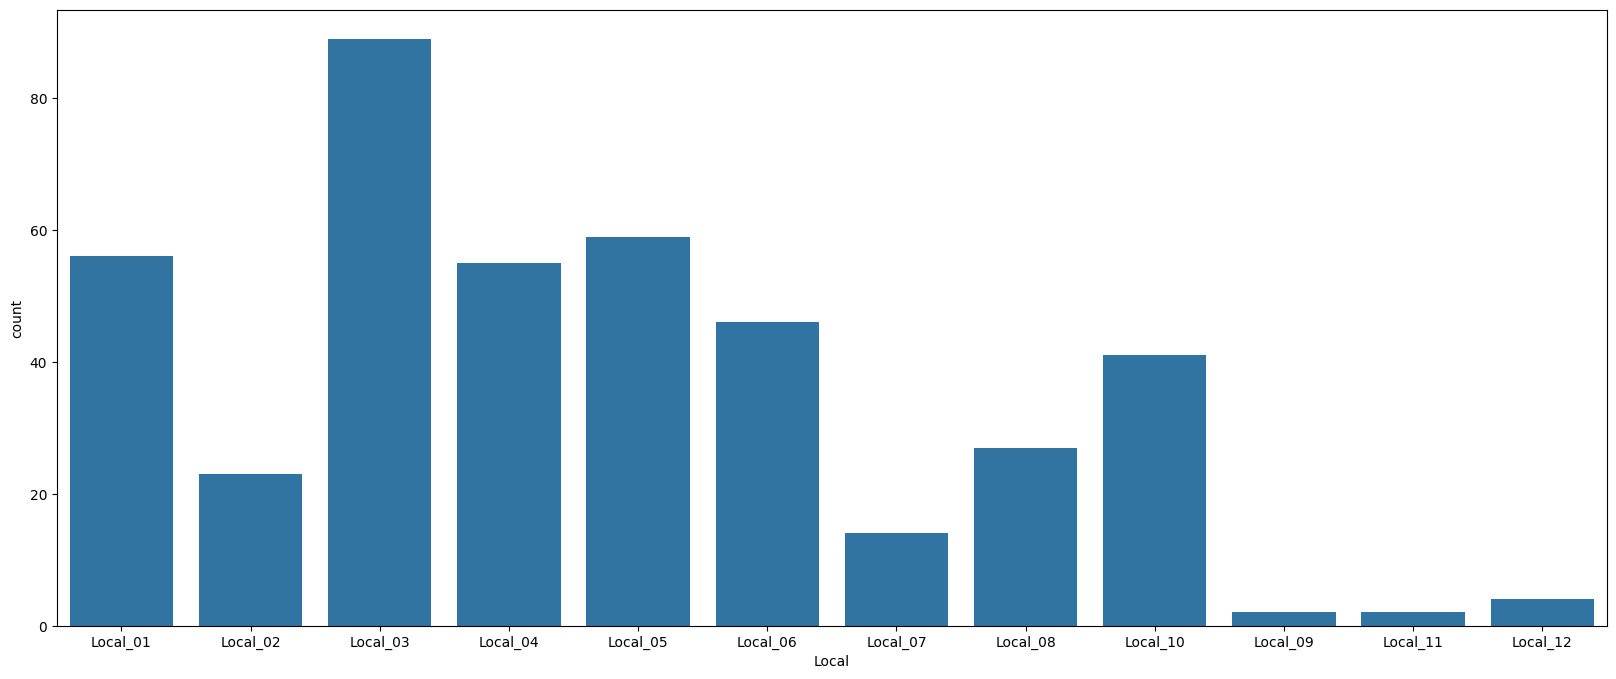

In [ ]:
#Checking the distribution of Local
plt.figure(figsize=(20,8))
sns.countplot(data = df, x = 'Local')

Local-03 has the highest accident

<Axes: xlabel='Potential Accident Level', ylabel='count'>

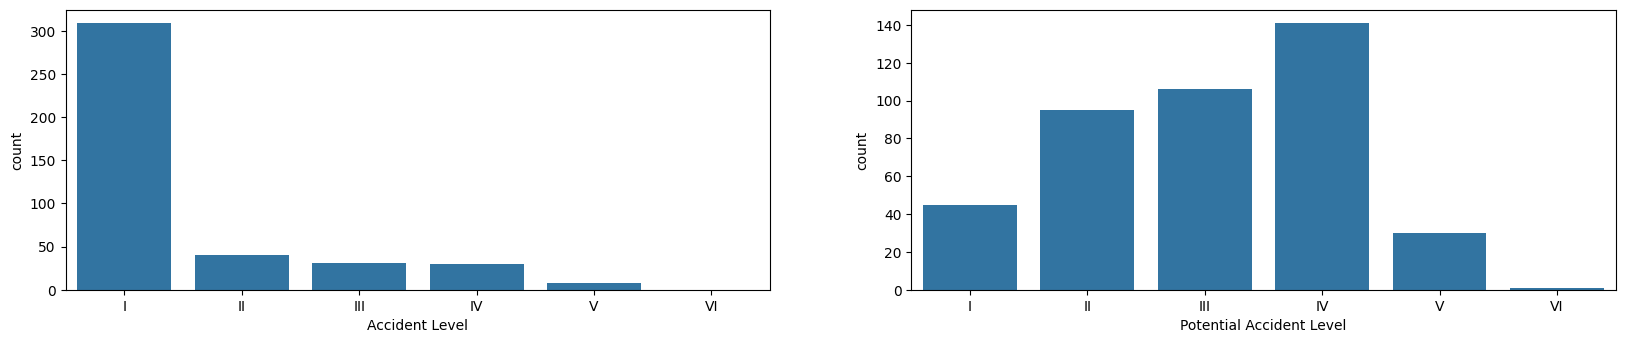

In [ ]:
#Checking the distribution of Target variable
plt.figure(figsize=(20,8))
plt.subplot(2,2,1)
sns.countplot(data = df, x = 'Accident Level',order=['I','II','III','IV','V','VI'])
plt.subplot(2,2,2)
sns.countplot(data = df, x = 'Potential Accident Level',order=['I','II','III','IV','V','VI'])

* Majority of the accident is of level 1.
* No of accident decreases as severity increases.
* There are very few records for accident level VI and potential accident level VI. So we can merge accident level VI and potential accident level VI with V.

In [ ]:
#Replacing Accident Level VI with V
df['Accident Level'] = df['Accident Level'].replace('VI','V')
df['Potential Accident Level'] = df['Potential Accident Level'].replace('VI','V')

<Axes: ylabel='Employee Type'>

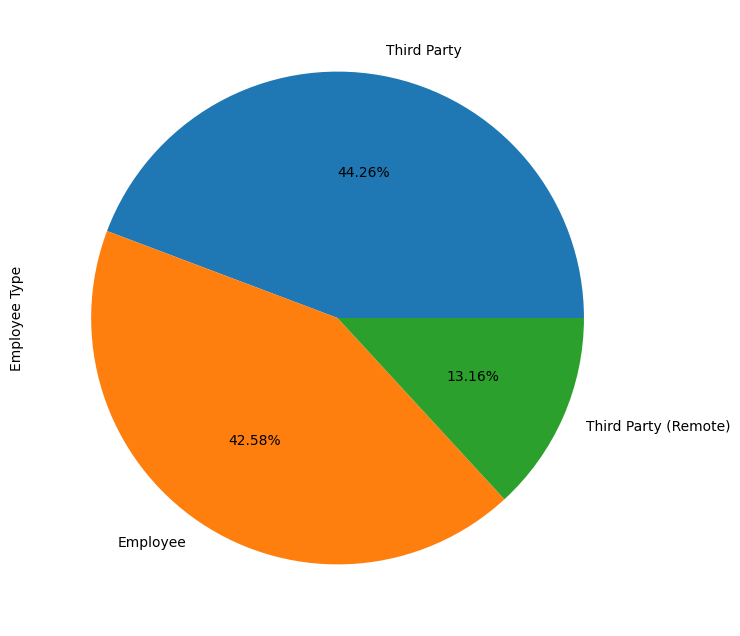

In [ ]:
#Checking the accident distribution Employee Type
plt.figure(figsize=(10,8))
df['Employee Type'].value_counts().plot(kind='pie',autopct='%.2f%%')

* 44.26% accidents happens in Third party.
* 42.585 accidents happens in Employee.
* 13.16% accidents happens in Third Party (Remote).

<Axes: xlabel='Year', ylabel='count'>

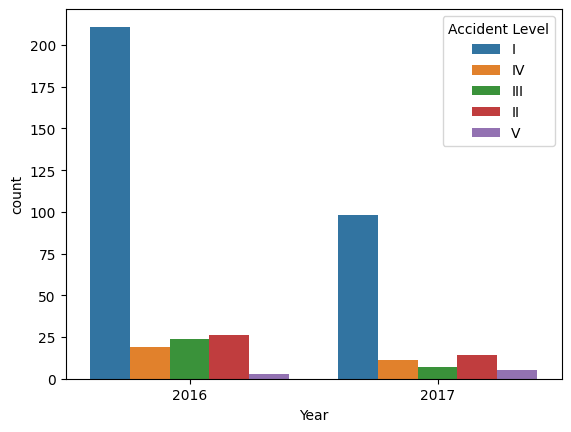

In [ ]:
#Checking the distribution of Year
sns.countplot(data = df, x = 'Year',hue='Accident Level')

In the year 2016 had more accident than in 2017

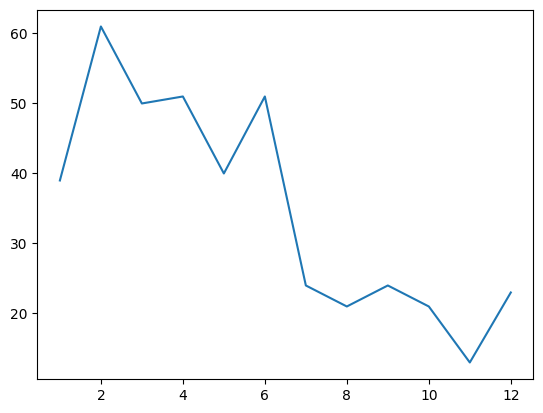

In [ ]:
#Checking the distribution of Month
plt.plot(df['Month'].value_counts().sort_index())

* Highest accident happend in February.
* November had lowest no of accident.

<Axes: xlabel='Day_name', ylabel='count'>

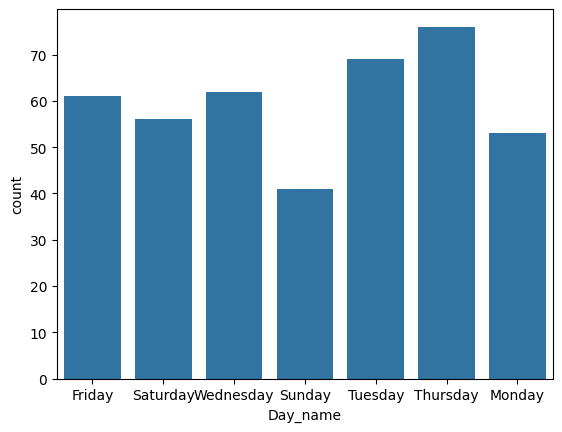

In [ ]:
#Checking the distribution of Day_name
sns.countplot(data = df, x = 'Day_name')

EDA Summary

1. There are 3 country types country_001, country_002, country_003 and highest number of incidents reported in country_001 and lowest incidents are reported in country_003

2. There are 12 local cities where manufacturing plants are located local_01 to local_12 and highest number of accidents are reported in local_03 and lowest number of accidents are reported in local_09 and local_11

3. There are only 3 Inustry Sectors and highest number of accidents are reported from Mining industry sector and lowest number of accidents are reported from others

4. There are only 5 Accident Levels , ranging from lowest severity I to highest severity V and highest number of accidents recorded are of severity Low I and lowest number of accidents recorded are of severity high V.

5. There are only 6 Potential Accident Levels , ranging from lowest severity I to highest severity VI and highest number Potential accidents are reported with severity low I and Lowest number of Potential accidents are reported with severity high VI .

6. There are 2 Genders male and female and highest number of accidents are recorded for male Gender and lowest of accidents are recorded for female gender

7. There are 3 employee types Third Party, Employee and Third Party ( Remote) and highest number of accidents are recorded for Third Party and lowest number of accidents are recorded for Third Party (Remote) .

8. Most of the Critical Risks are classified as others

9. Highest number of accidents are reported in the year 2016 and lowest in the year 2017


# NLP Data Preprocessing

Feature: Description

Target: Accident Level

In [ ]:
#Feature and Target variable
x = df['Description']
y = df['Accident Level']

Removing Accented Chracters

In [ ]:
def rmv_uni(sen):
  wrds = sen.split()
  new_sen = [unidecode.unidecode(w) for w in wrds]
  new_sen = ' '.join(new_sen)

  return new_sen

In [ ]:
x = x.apply(lambda x: rmv_uni(x))

Removing Special Characters

In [ ]:
def rmv_schar(s):
  wrds = s.split()
  new_text = [w for w in wrds if w.isalnum()]
  new_text = ' '.join(new_text)

  return new_text

In [ ]:
x = x.apply(lambda x: rmv_schar(x))

Lowercasing All The Letters

In [ ]:
def lower_case(s):
  s = s.lower()
  return s

In [ ]:
x = x.apply(lambda x: lower_case(x))

In [ ]:
x

0      while removing the drill rod of the jumbo 08 f...
1      during the activation of a sodium sulphide the...
2      in the milpo located at level when the collabo...
3      being approximately in the 1880 the personnel ...
4      approximately at in circumstances that the mec...
                             ...                        
420    being approximately when lifting the kelly hq ...
421    the collaborator moved from the infrastructure...
422    during the environmental monitoring activity i...
423    the employee performed the activity of strippi...
424    at when the assistant cleaned the floor of mod...
Name: Description, Length: 418, dtype: object

Wordcloud

In [ ]:
all_texts = ' '.join(text for text in x)

Total cumber words after removing stopwords: 131089


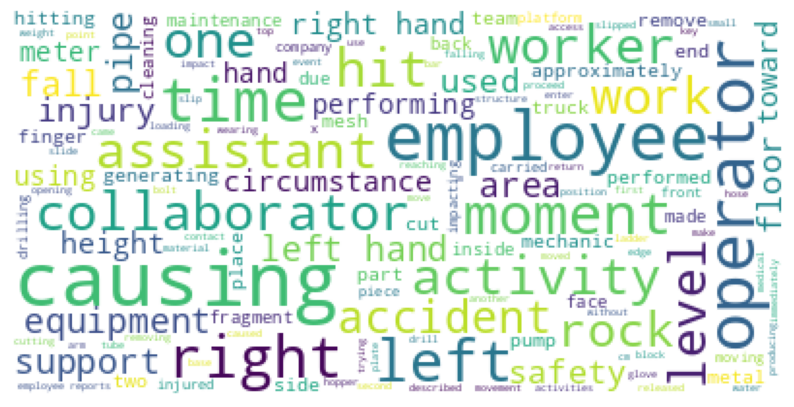

In [ ]:
#Generate wordcloud
all_texts = ' '.join(text for text in x)
print('Total cumber words after removing stopwords:', len(all_texts))
wrd_cld = WordCloud(max_font_size = 40, max_words=300, background_color="white")
cloud = wrd_cld.generate(all_texts)
plt.figure(figsize=(10,10))
plt.imshow(cloud)
plt.axis("off")
plt.show()

Removing Stopwords

In [ ]:
def rmv_stpwrds(sen):
  wrds = sen.split()
  new_text = [w for w in wrds if w not in stopwords.words('english')]
  new_text = ' '.join(new_text)

  return new_text


In [ ]:
x= x.apply(lambda x: rmv_stpwrds(x))

Wordcloud after Removing Stopwords

Total cumber words after removing stopwords: 83076


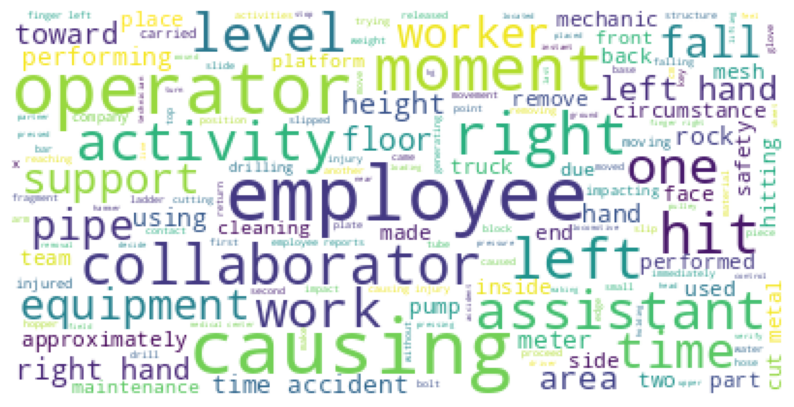

In [ ]:
#Generate wordcloud
all_texts = ' '.join(text for text in x)
print('Total cumber words after removing stopwords:', len(all_texts))
wrd_cld = WordCloud(max_font_size = 40, max_words=300, background_color="white")
cloud = wrd_cld.generate(all_texts)
plt.figure(figsize=(10,10))
plt.imshow(cloud)
plt.axis("off")
plt.show()

Lemmatizing the Words

In [ ]:
lemmatizer = WordNetLemmatizer()

def stem(sen):
  wrds = sen.split()
  new_text = [lemmatizer.lemmatize(w) for w in wrds]
  new_text =  ' '.join(new_text)

  return new_text

In [ ]:
x = x.apply(lambda x: stem(x))

Stripping the Extra Spaces

In [ ]:
def strp(sen):
  sen = sen.strip()
  return sen

In [ ]:
x = x.apply(lambda x: strp(x))

In [ ]:
#Adding preprocessed description in the dataframe
df['Cleaned_description'] = x

In [ ]:
df.head()

,Date,Country,Local,Industry Sector,Accident Level,Potential Accident Level,Gender,Employee Type,Critical Risk,Description,Year,Day,Month,Day_name,Cleaned_description
0,2016-01-01,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,2016,1,1,Friday,removing drill rod jumbo 08 supervisor proceed...
1,2016-01-02,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,2016,2,1,Saturday,activation sodium sulphide piping uncoupled su...
2,2016-01-06,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,2016,6,1,Wednesday,milpo located level collaborator excavation wo...
3,2016-01-08,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...,2016,8,1,Friday,approximately 1880 personnel begin task unlock...
4,2016-01-10,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...,2016,10,1,Sunday,approximately circumstance mechanic anthony ed...


In [ ]:
#Saving preprocessed data into csv file
df.to_csv('Preprocessed_Dataset_chatbot.csv')

# Data Preparation

Vectorization using TF-IDF Vectorizer

In [ ]:
#Vectorization using tfidf
vec = TfidfVectorizer(max_features = 300)
x_vec = vec.fit_transform(x).toarray()

In [ ]:
#Splitting data into train and test
x_train, x_test, y_train, y_test = train_test_split(x_vec,y,train_size=0.8,random_state=1)

# Model Building

In [ ]:
#Creating function to trained the model
def train_test(models, x_train,y_train,x_test,y_test):

  for name, model in models.items():
    print("\nModel Name:", name)
    model.fit(x_train,y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    print('\nTraining Accuracy: ',model.score(x_train,y_train))
    print('Testing Accuracy: ',model.score(x_test,y_test))


    print('\nConfusion matrix for training set:\n')
    model_cm_train = confusion_matrix(y_train, y_train_pred)
    sns.heatmap(model_cm_train, annot=True,  fmt='.2f', xticklabels = ["I", "II", "III", "IV", "V"] , yticklabels = ["I", "II", "III", "IV", "V"] )
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    print('\nConfusion matrix for testing set:\n')
    model_cm_test = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(model_cm_test, annot=True,  fmt='.2f', xticklabels = ["I", "II", "III", "IV", "V"] , yticklabels = ["I", "II", "III", "IV", "V"] )
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print('************************************************************************')
    print('\nClassification report for Training set:\n')
    print(classification_report(y_train,y_train_pred))

    print('\nClassification report for Testing set:\n')
    print(classification_report(y_test,y_test_pred))
    print('************************************************************************')


In [ ]:
#Function for Hyperparameter Tunning
def hyperparameter_tunning(model,x_train,y_train,params):
  cv = StratifiedKFold(n_splits=10)
  grid_search = GridSearchCV(estimator=model,param_grid=params)
  result = grid_search.fit(x_train, y_train)
  print("Best Score: " , result.best_score_)
  print("Best Parameter:",result.best_params_)
  means = result.cv_results_['mean_test_score']
  stds = result.cv_results_['std_test_score']
  params = result.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
    if param == result.best_params_:
      print("95% Confidence interval range: ({0:.4f} %, {1:.4f} %)".format(mean-(2*stdev), mean+(2*stdev)))
  return result.best_params_

Training Basic Classifier

In [ ]:
#Defining the models
models = dict({'Naive Bayes without Sampling':MultinomialNB(),'KNearest Neighbor without Sampling':KNeighborsClassifier(),'Logistic Regression without Sampling':LogisticRegression(),
               'SVM without Sampling':SVC(),'Decision Tree without Sampling':DecisionTreeClassifier(),'Random Forest without Sampling':RandomForestClassifier(),
               'Ada Boost without Sampling':AdaBoostClassifier(),'Gradient Boost without Sampling':GradientBoostingClassifier()})


Model Name: Naive Bayes without Sampling

Training Accuracy:  0.7604790419161677
Testing Accuracy:  0.6547619047619048

Confusion matrix for training set:



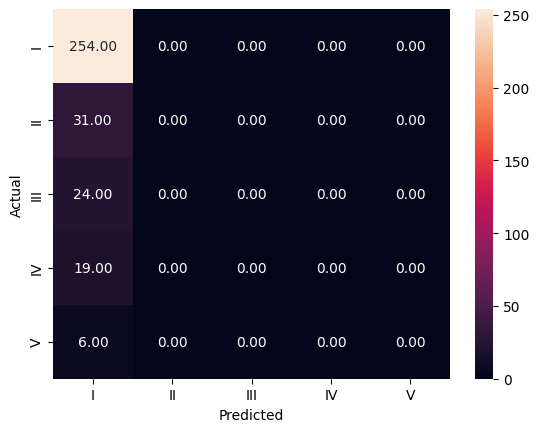


Confusion matrix for testing set:



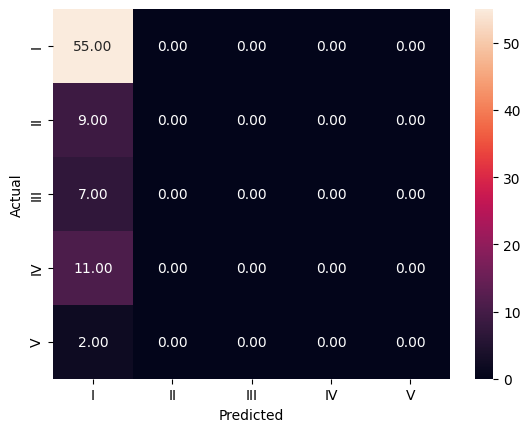

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7c68da5c7250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 847, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 984, in _make_controller_from_path
    lib_controller = controller_class(filepath=filepath, prefix=prefix)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 111, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-5007b62f.3.23.dev.so: cannot open shared object file: No such file or directory


************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           I       0.76      1.00      0.86       254
          II       0.00      0.00      0.00        31
         III       0.00      0.00      0.00        24
          IV       0.00      0.00      0.00        19
           V       0.00      0.00      0.00         6

    accuracy                           0.76       334
   macro avg       0.15      0.20      0.17       334
weighted avg       0.58      0.76      0.66       334


Classification report for Testing set:

              precision    recall  f1-score   support

           I       0.65      1.00      0.79        55
          II       0.00      0.00      0.00         9
         III       0.00      0.00      0.00         7
          IV       0.00      0.00      0.00        11
           V       0.00      0.00      0.00         2

    accuracy                 

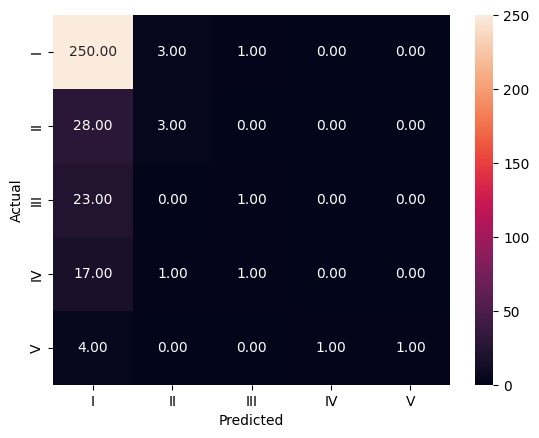


Confusion matrix for testing set:



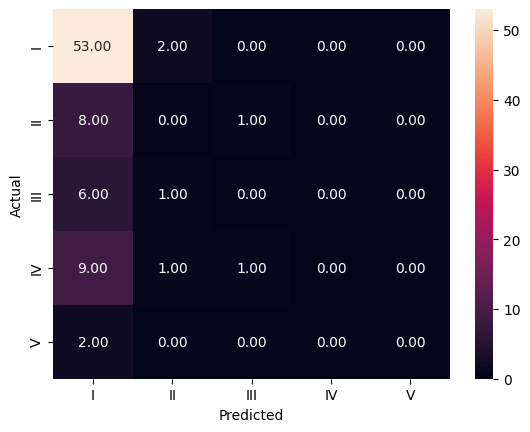

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           I       0.78      0.98      0.87       254
          II       0.43      0.10      0.16        31
         III       0.33      0.04      0.07        24
          IV       0.00      0.00      0.00        19
           V       1.00      0.17      0.29         6

    accuracy                           0.76       334
   macro avg       0.51      0.26      0.28       334
weighted avg       0.67      0.76      0.69       334


Classification report for Testing set:

              precision    recall  f1-score   support

           I       0.68      0.96      0.80        55
          II       0.00      0.00      0.00         9
         III       0.00      0.00      0.00         7
          IV       0.00      0.00      0.00        11
           V       0.00      0.00      0.00         2

    accuracy                 

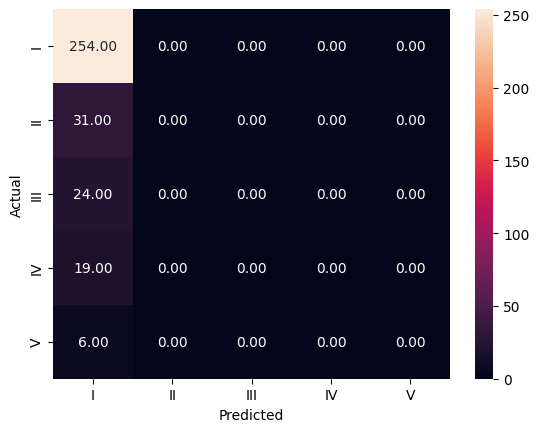


Confusion matrix for testing set:



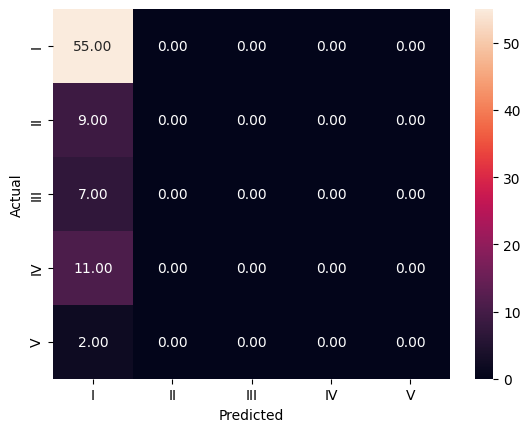

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           I       0.76      1.00      0.86       254
          II       0.00      0.00      0.00        31
         III       0.00      0.00      0.00        24
          IV       0.00      0.00      0.00        19
           V       0.00      0.00      0.00         6

    accuracy                           0.76       334
   macro avg       0.15      0.20      0.17       334
weighted avg       0.58      0.76      0.66       334


Classification report for Testing set:

              precision    recall  f1-score   support

           I       0.65      1.00      0.79        55
          II       0.00      0.00      0.00         9
         III       0.00      0.00      0.00         7
          IV       0.00      0.00      0.00        11
           V       0.00      0.00      0.00         2

    accuracy                 

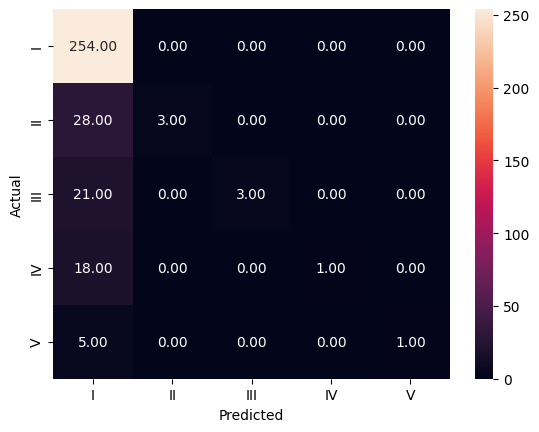


Confusion matrix for testing set:



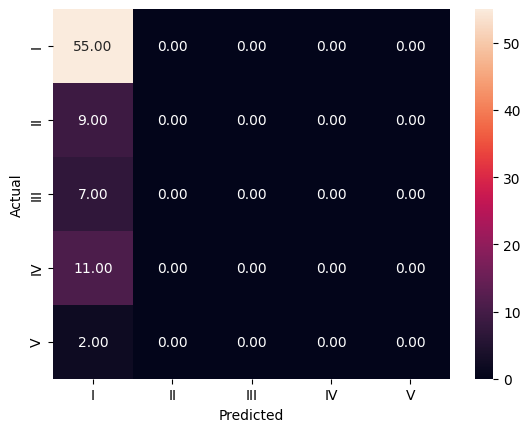

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           I       0.78      1.00      0.88       254
          II       1.00      0.10      0.18        31
         III       1.00      0.12      0.22        24
          IV       1.00      0.05      0.10        19
           V       1.00      0.17      0.29         6

    accuracy                           0.78       334
   macro avg       0.96      0.29      0.33       334
weighted avg       0.83      0.78      0.71       334


Classification report for Testing set:

              precision    recall  f1-score   support

           I       0.65      1.00      0.79        55
          II       0.00      0.00      0.00         9
         III       0.00      0.00      0.00         7
          IV       0.00      0.00      0.00        11
           V       0.00      0.00      0.00         2

    accuracy                 

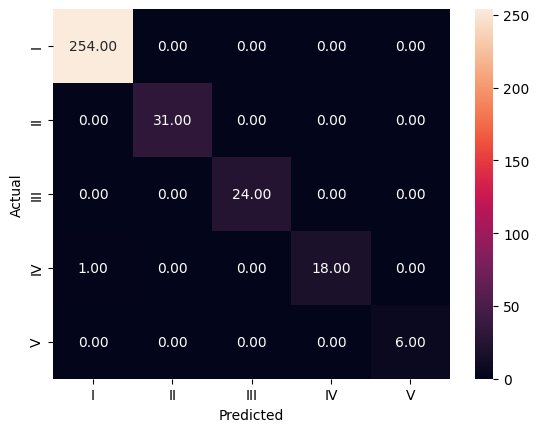


Confusion matrix for testing set:



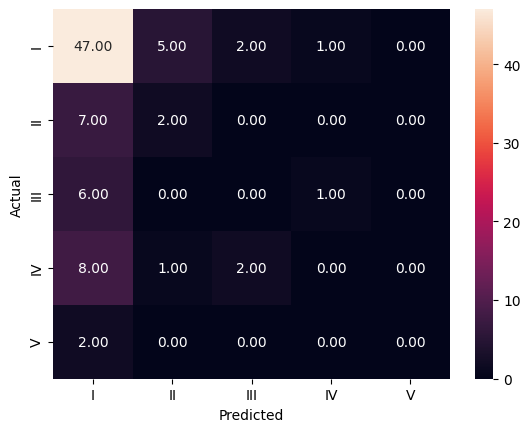

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           I       1.00      1.00      1.00       254
          II       1.00      1.00      1.00        31
         III       1.00      1.00      1.00        24
          IV       1.00      0.95      0.97        19
           V       1.00      1.00      1.00         6

    accuracy                           1.00       334
   macro avg       1.00      0.99      0.99       334
weighted avg       1.00      1.00      1.00       334


Classification report for Testing set:

              precision    recall  f1-score   support

           I       0.67      0.85      0.75        55
          II       0.25      0.22      0.24         9
         III       0.00      0.00      0.00         7
          IV       0.00      0.00      0.00        11
           V       0.00      0.00      0.00         2

    accuracy                 

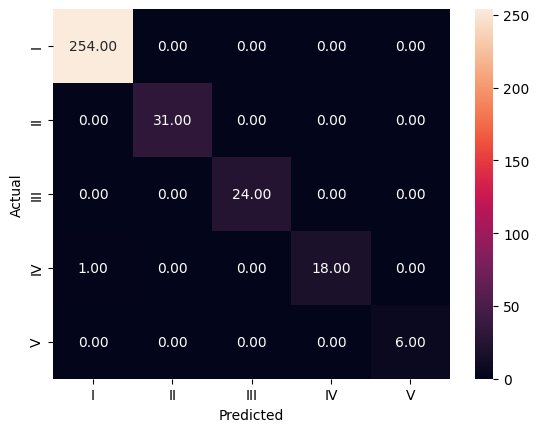


Confusion matrix for testing set:



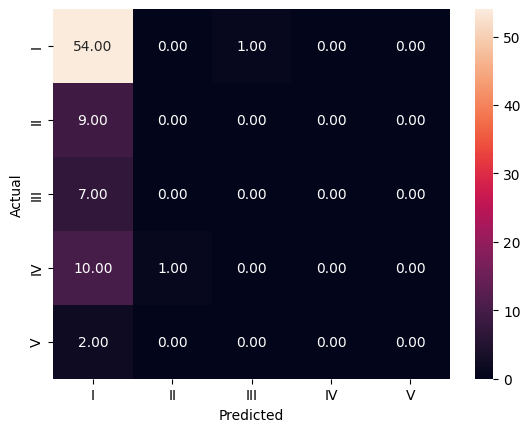

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           I       1.00      1.00      1.00       254
          II       1.00      1.00      1.00        31
         III       1.00      1.00      1.00        24
          IV       1.00      0.95      0.97        19
           V       1.00      1.00      1.00         6

    accuracy                           1.00       334
   macro avg       1.00      0.99      0.99       334
weighted avg       1.00      1.00      1.00       334


Classification report for Testing set:

              precision    recall  f1-score   support

           I       0.66      0.98      0.79        55
          II       0.00      0.00      0.00         9
         III       0.00      0.00      0.00         7
          IV       0.00      0.00      0.00        11
           V       0.00      0.00      0.00         2

    accuracy                 

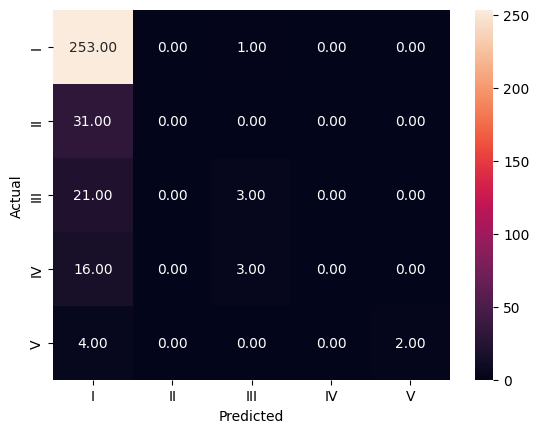


Confusion matrix for testing set:



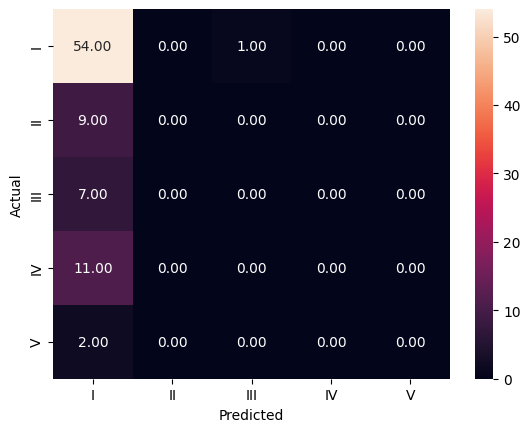

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           I       0.78      1.00      0.87       254
          II       0.00      0.00      0.00        31
         III       0.43      0.12      0.19        24
          IV       0.00      0.00      0.00        19
           V       1.00      0.33      0.50         6

    accuracy                           0.77       334
   macro avg       0.44      0.29      0.31       334
weighted avg       0.64      0.77      0.69       334


Classification report for Testing set:

              precision    recall  f1-score   support

           I       0.65      0.98      0.78        55
          II       0.00      0.00      0.00         9
         III       0.00      0.00      0.00         7
          IV       0.00      0.00      0.00        11
           V       0.00      0.00      0.00         2

    accuracy                 

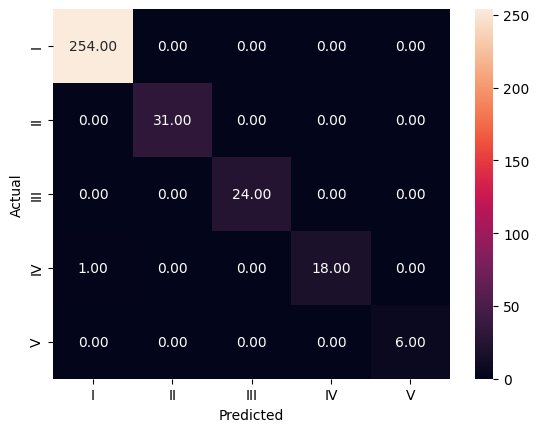


Confusion matrix for testing set:



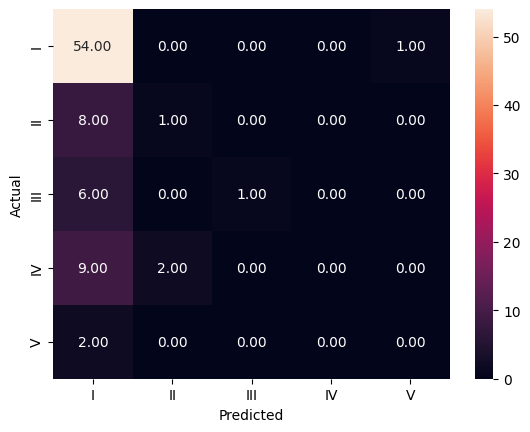

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           I       1.00      1.00      1.00       254
          II       1.00      1.00      1.00        31
         III       1.00      1.00      1.00        24
          IV       1.00      0.95      0.97        19
           V       1.00      1.00      1.00         6

    accuracy                           1.00       334
   macro avg       1.00      0.99      0.99       334
weighted avg       1.00      1.00      1.00       334


Classification report for Testing set:

              precision    recall  f1-score   support

           I       0.68      0.98      0.81        55
          II       0.33      0.11      0.17         9
         III       1.00      0.14      0.25         7
          IV       0.00      0.00      0.00        11
           V       0.00      0.00      0.00         2

    accuracy                 

In [ ]:
#Training all Models
train_test(models,x_train,y_train,x_test,y_test)

# Comparing all the models (without sampling)

In [ ]:
# Function to get the metrics score
def get_metrics_score(model):

  score_list = []

  pred_train = model.predict(x_train)
  pred_test = model.predict(x_test)

  train_acc = round(model.score(x_train,y_train)*100,2)
  test_acc = round(model.score(x_test,y_test)*100,2)

  train_recall = round(recall_score(y_train,pred_train,average='weighted')*100,2)
  test_recall = round(recall_score(y_test,pred_test,average='weighted')*100,2)

  train_precision = round(precision_score(y_train,pred_train,average='weighted')*100,2)
  test_precision = round(precision_score(y_test,pred_test,average='weighted')*100,2)

  train_f1 = round(f1_score(y_train,pred_train,average='weighted')*100,2)
  test_f1 = round(f1_score(y_test,pred_test,average='weighted')*100,2)

  score_list.append([train_acc,test_acc,train_recall,test_recall,train_precision,test_precision,train_f1,test_f1])

  return score_list

In [ ]:

#Creating empty list to add train and test results
methods = []
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []
f1_train = []
f1_test = []
#looping through the models
for name,model in models.items():
  methods.append(name)
  j = get_metrics_score(model)
  acc_train.append((j[0][0]))
  acc_test.append((j[0][1]))
  recall_train.append((j[0][2]))
  recall_test.append((j[0][3]))
  precision_train.append((j[0][4]))
  precision_test.append((j[0][5]))
  f1_train.append((j[0][6]))
  f1_test.append((j[0][7]))

In [ ]:
#Creating Dataframe
comparison_frame = pd.DataFrame({'Methods':methods,
                                          'Train_Accuracy': acc_train,'Test_Accuracy': acc_test,
                                          'Train_Recall':recall_train,'Test_Recall':recall_test,
                                          'Train_Precision':precision_train,'Test_Precision':precision_test,
                                          'Train_F1':f1_train,
                                          'Test_F1':f1_test  })

#Sorting models in decreasing order of test accuracy
comparison_frame.sort_values(by='Test_F1',ascending=False)

,Methods,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision,Train_F1,Test_F1
7,Gradient Boost without Sampling,99.70,66.67,99.70,66.67,99.70,56.66,99.70,56.64
1,KNearest Neighbor without Sampling,76.35,63.10,76.35,63.10,67.21,44.49,68.52,52.18
0,Naive Bayes without Sampling,76.05,65.48,76.05,65.48,57.83,42.87,65.70,51.82
2,Logistic Regression without Sampling,76.05,65.48,76.05,65.48,57.83,42.87,65.70,51.82
3,SVM without Sampling,78.44,65.48,78.44,65.48,83.20,42.87,70.92,51.82
4,Decision Tree without Sampling,99.70,58.33,99.70,58.33,99.70,46.64,99.70,51.76
5,Random Forest without Sampling,99.70,64.29,99.70,64.29,99.70,43.12,99.70,51.62
6,Ada Boost without Sampling,77.25,64.29,77.25,64.29,64.08,42.60,68.75,51.24


Random Forest model have highest f1 score for test data, although all the models are overfitting.

# Tunning the Models

Naive Bayes

In [ ]:
params_nb = {'alpha':np.logspace(0,-9, num=10)}
nb_param = hyperparameter_tunning(models['Naive Bayes without Sampling'],x_train,y_train,params_nb)

Best Score:  0.7604703753957486
Best Parameter: {'alpha': 1.0}
95% Confidence interval range: (0.7576 %, 0.7634 %)


KNearest Neighbor

In [ ]:
params_knn = {'leaf_size':list(range(1,100)),'n_neighbors':list(range(3, 16, 2)),'weights' : ['uniform', 'distance'],'metric' : ['euclidean', 'manhattan']}
knn_param = hyperparameter_tunning(models['KNearest Neighbor without Sampling'],x_train,y_train,params_knn)

Best Score:  0.7604703753957486
Best Parameter: {'leaf_size': 1, 'metric': 'euclidean', 'n_neighbors': 13, 'weights': 'uniform'}
95% Confidence interval range: (0.7576 %, 0.7634 %)


Logistic Regression

In [ ]:
params_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l2'],
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']
}
lr_param = hyperparameter_tunning(models['Logistic Regression without Sampling'],x_train,y_train,params_lr)

Best Score:  0.7604703753957486
Best Parameter: {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}
95% Confidence interval range: (0.7576 %, 0.7634 %)


SVM

In [ ]:
params_svm = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
svm_param = hyperparameter_tunning(models['SVM without Sampling'],x_train,y_train,params_svm)

Best Score:  0.7604703753957486
Best Parameter: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
95% Confidence interval range: (0.7576 %, 0.7634 %)


Decision Tree

In [ ]:
params_dt = {'max_depth': [2, 3, 5, 7, 10,15, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100, 200, 300],
    'criterion': ["gini", "entropy"]}
dt_param = hyperparameter_tunning(models['Decision Tree without Sampling'],x_train,y_train,params_dt)

Best Score:  0.7604703753957486
Best Parameter: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 20}
95% Confidence interval range: (0.7576 %, 0.7634 %)


Random Forest

In [ ]:
params_rf = {'n_estimators': [150,200,250],
    'max_features':[0.2,0.3,0.4,0.5,0.6],
    'max_samples': [0.3,0.4,0.5,0.6]}
rf_param = hyperparameter_tunning(models['Random Forest without Sampling'],x_train,y_train,params_rf)

Best Score:  0.7604703753957486
Best Parameter: {'max_features': 0.2, 'max_samples': 0.3, 'n_estimators': 150}
95% Confidence interval range: (0.7576 %, 0.7634 %)


Ada Boost

In [ ]:
params_ada = {'n_estimators': [50, 100,150,200,250],'algorithm' : ['SAMME','SAMME.R'],
                        'learning_rate':[0.0001, 0.01, 0.1, 1.0, 1.1, 1.2]}
ada_param = hyperparameter_tunning(models['Ada Boost without Sampling'],x_train,y_train,params_ada)

Best Score:  0.7604703753957486
Best Parameter: {'algorithm': 'SAMME', 'learning_rate': 0.01, 'n_estimators': 100}
95% Confidence interval range: (0.7576 %, 0.7634 %)


Gradient Boost

In [ ]:
params_gb = {'n_estimators': [100, 150,200],'max_depth':np.arange(3,7,1),
                         'max_features':np.arange(0.2,0.6,0.1)
                        }
gb_param = hyperparameter_tunning(models['Gradient Boost without Sampling'],x_train,y_train,params_gb)

Best Score:  0.7096788783355947
Best Parameter: {'max_depth': 5, 'max_features': 0.2, 'n_estimators': 150}
95% Confidence interval range: (0.6172 %, 0.8022 %)


In [ ]:
#Defining the models
models_tunned = dict({'Tunned Naive Bayes without Sampling':MultinomialNB(**nb_param),'Tunned KNearest Neighbor without Sampling':KNeighborsClassifier(**knn_param),'Tunned Logistic Regression without Sampling':LogisticRegression(**lr_param),
               'Tunned SVM without Sampling':SVC(**svm_param),'Tunned Decision Tree without Sampling':DecisionTreeClassifier(**dt_param),'Tunned Random Forest without Sampling':RandomForestClassifier(**rf_param),
               'Tunned Ada Boost without Sampling':AdaBoostClassifier(**ada_param),'Tunned Gradient Boost without Sampling':GradientBoostingClassifier(**gb_param)})


Model Name: Tunned Naive Bayes without Sampling

Training Accuracy:  0.7604790419161677
Testing Accuracy:  0.6547619047619048

Confusion matrix for training set:



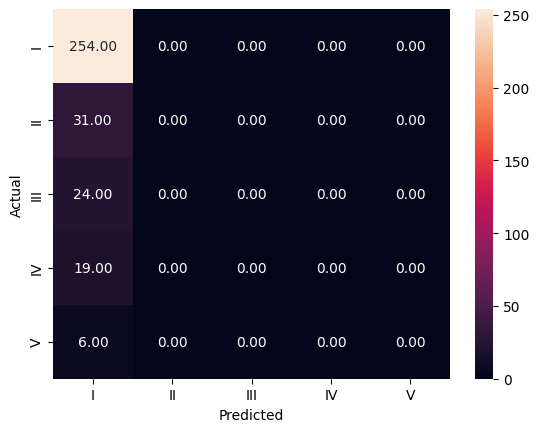


Confusion matrix for testing set:



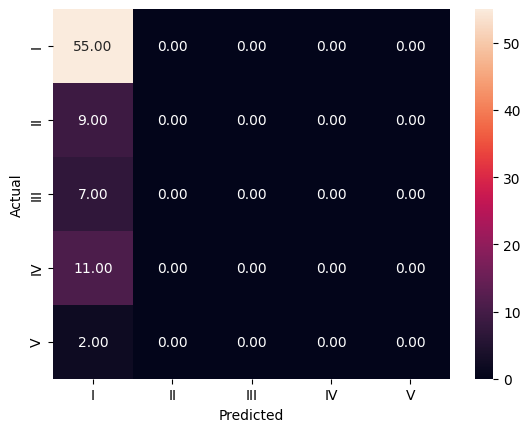

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           I       0.76      1.00      0.86       254
          II       0.00      0.00      0.00        31
         III       0.00      0.00      0.00        24
          IV       0.00      0.00      0.00        19
           V       0.00      0.00      0.00         6

    accuracy                           0.76       334
   macro avg       0.15      0.20      0.17       334
weighted avg       0.58      0.76      0.66       334


Classification report for Testing set:

              precision    recall  f1-score   support

           I       0.65      1.00      0.79        55
          II       0.00      0.00      0.00         9
         III       0.00      0.00      0.00         7
          IV       0.00      0.00      0.00        11
           V       0.00      0.00      0.00         2

    accuracy                 

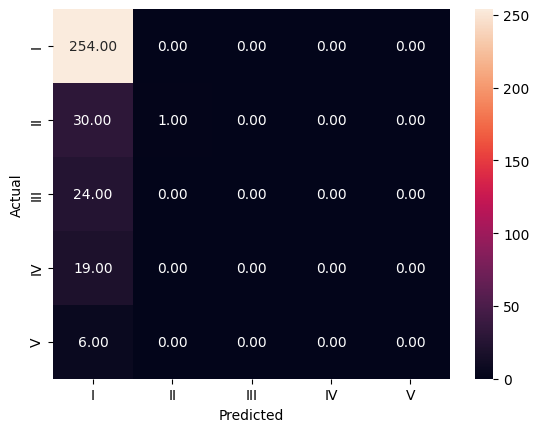


Confusion matrix for testing set:



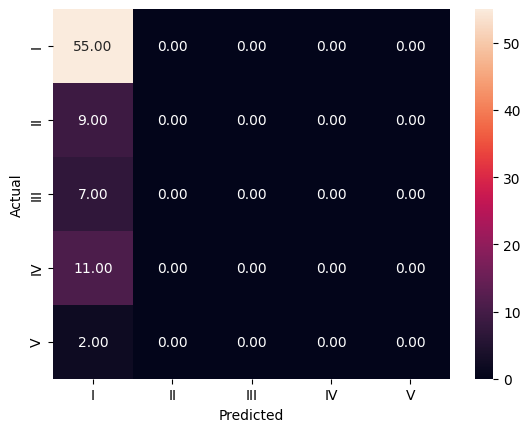

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           I       0.76      1.00      0.87       254
          II       1.00      0.03      0.06        31
         III       0.00      0.00      0.00        24
          IV       0.00      0.00      0.00        19
           V       0.00      0.00      0.00         6

    accuracy                           0.76       334
   macro avg       0.35      0.21      0.19       334
weighted avg       0.67      0.76      0.66       334


Classification report for Testing set:

              precision    recall  f1-score   support

           I       0.65      1.00      0.79        55
          II       0.00      0.00      0.00         9
         III       0.00      0.00      0.00         7
          IV       0.00      0.00      0.00        11
           V       0.00      0.00      0.00         2

    accuracy                 

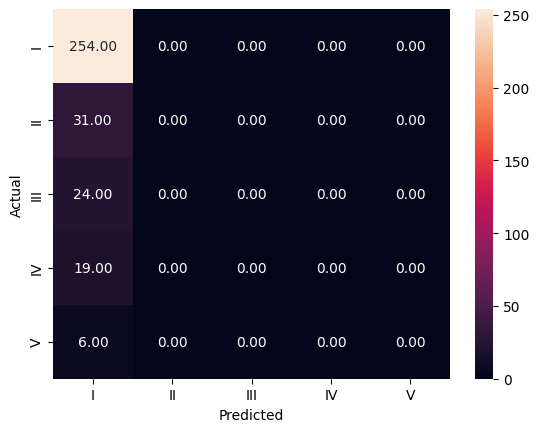


Confusion matrix for testing set:



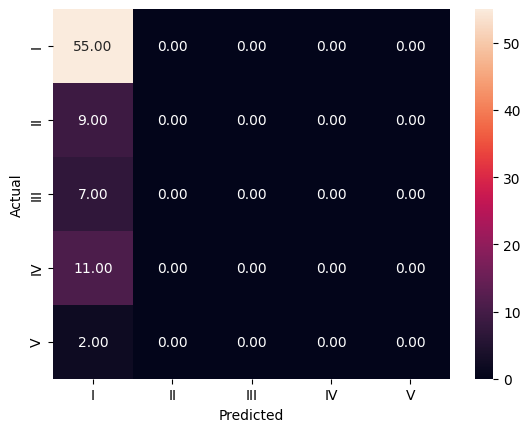

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           I       0.76      1.00      0.86       254
          II       0.00      0.00      0.00        31
         III       0.00      0.00      0.00        24
          IV       0.00      0.00      0.00        19
           V       0.00      0.00      0.00         6

    accuracy                           0.76       334
   macro avg       0.15      0.20      0.17       334
weighted avg       0.58      0.76      0.66       334


Classification report for Testing set:

              precision    recall  f1-score   support

           I       0.65      1.00      0.79        55
          II       0.00      0.00      0.00         9
         III       0.00      0.00      0.00         7
          IV       0.00      0.00      0.00        11
           V       0.00      0.00      0.00         2

    accuracy                 

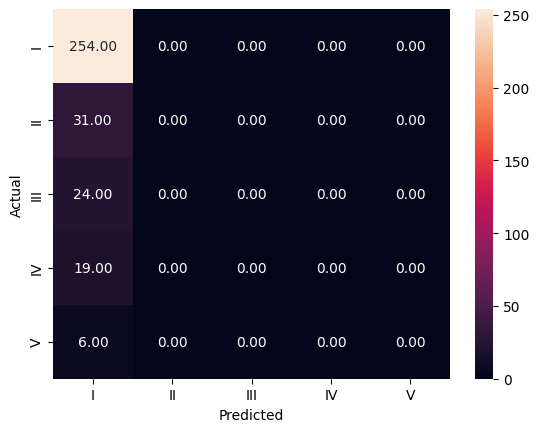


Confusion matrix for testing set:



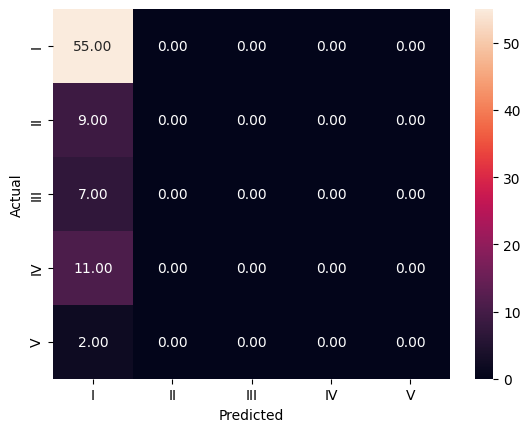

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           I       0.76      1.00      0.86       254
          II       0.00      0.00      0.00        31
         III       0.00      0.00      0.00        24
          IV       0.00      0.00      0.00        19
           V       0.00      0.00      0.00         6

    accuracy                           0.76       334
   macro avg       0.15      0.20      0.17       334
weighted avg       0.58      0.76      0.66       334


Classification report for Testing set:

              precision    recall  f1-score   support

           I       0.65      1.00      0.79        55
          II       0.00      0.00      0.00         9
         III       0.00      0.00      0.00         7
          IV       0.00      0.00      0.00        11
           V       0.00      0.00      0.00         2

    accuracy                 

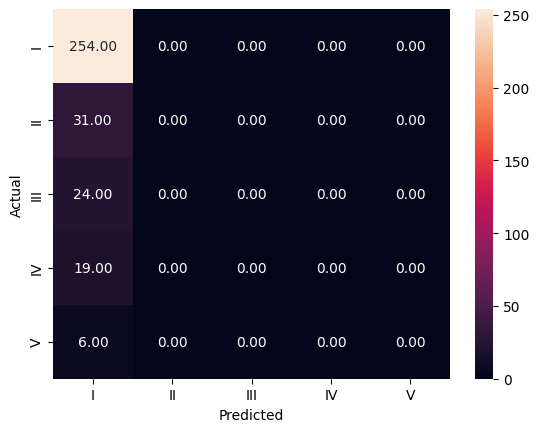


Confusion matrix for testing set:



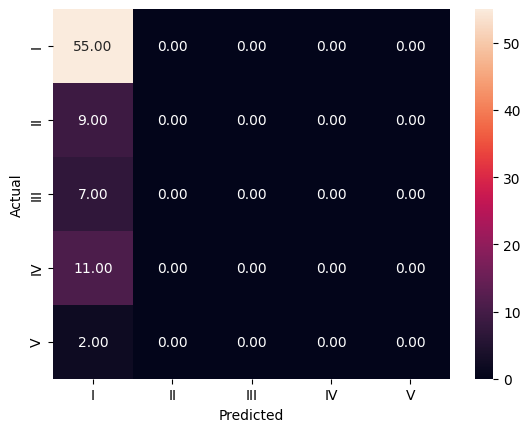

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           I       0.76      1.00      0.86       254
          II       0.00      0.00      0.00        31
         III       0.00      0.00      0.00        24
          IV       0.00      0.00      0.00        19
           V       0.00      0.00      0.00         6

    accuracy                           0.76       334
   macro avg       0.15      0.20      0.17       334
weighted avg       0.58      0.76      0.66       334


Classification report for Testing set:

              precision    recall  f1-score   support

           I       0.65      1.00      0.79        55
          II       0.00      0.00      0.00         9
         III       0.00      0.00      0.00         7
          IV       0.00      0.00      0.00        11
           V       0.00      0.00      0.00         2

    accuracy                 

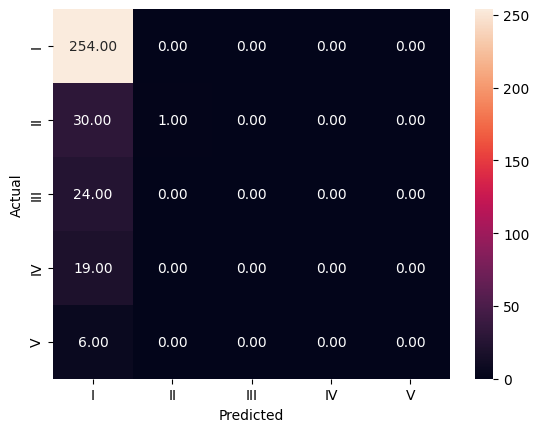


Confusion matrix for testing set:



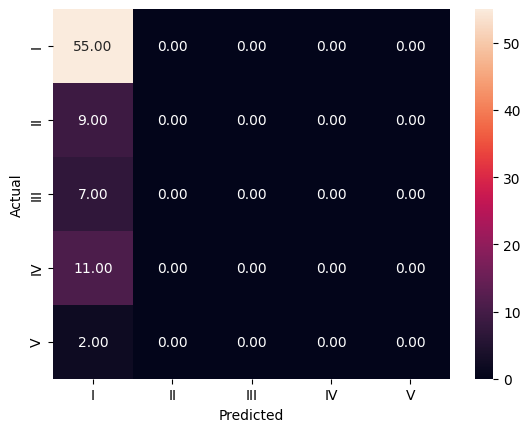

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           I       0.76      1.00      0.87       254
          II       1.00      0.03      0.06        31
         III       0.00      0.00      0.00        24
          IV       0.00      0.00      0.00        19
           V       0.00      0.00      0.00         6

    accuracy                           0.76       334
   macro avg       0.35      0.21      0.19       334
weighted avg       0.67      0.76      0.66       334


Classification report for Testing set:

              precision    recall  f1-score   support

           I       0.65      1.00      0.79        55
          II       0.00      0.00      0.00         9
         III       0.00      0.00      0.00         7
          IV       0.00      0.00      0.00        11
           V       0.00      0.00      0.00         2

    accuracy                 

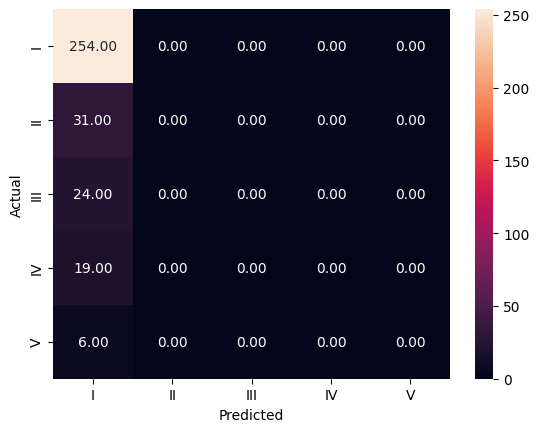


Confusion matrix for testing set:



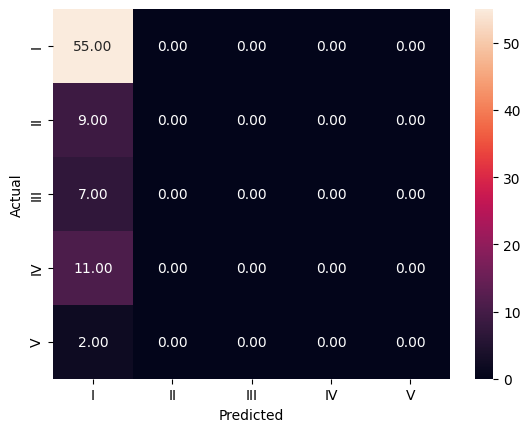

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           I       0.76      1.00      0.86       254
          II       0.00      0.00      0.00        31
         III       0.00      0.00      0.00        24
          IV       0.00      0.00      0.00        19
           V       0.00      0.00      0.00         6

    accuracy                           0.76       334
   macro avg       0.15      0.20      0.17       334
weighted avg       0.58      0.76      0.66       334


Classification report for Testing set:

              precision    recall  f1-score   support

           I       0.65      1.00      0.79        55
          II       0.00      0.00      0.00         9
         III       0.00      0.00      0.00         7
          IV       0.00      0.00      0.00        11
           V       0.00      0.00      0.00         2

    accuracy                 

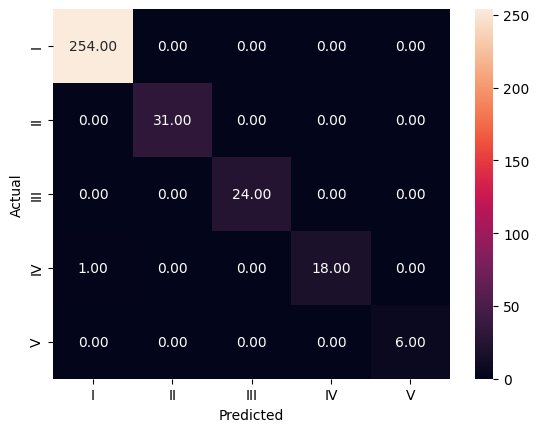


Confusion matrix for testing set:



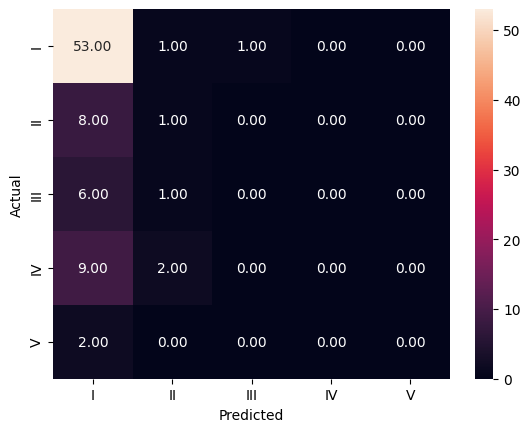

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           I       1.00      1.00      1.00       254
          II       1.00      1.00      1.00        31
         III       1.00      1.00      1.00        24
          IV       1.00      0.95      0.97        19
           V       1.00      1.00      1.00         6

    accuracy                           1.00       334
   macro avg       1.00      0.99      0.99       334
weighted avg       1.00      1.00      1.00       334


Classification report for Testing set:

              precision    recall  f1-score   support

           I       0.68      0.96      0.80        55
          II       0.20      0.11      0.14         9
         III       0.00      0.00      0.00         7
          IV       0.00      0.00      0.00        11
           V       0.00      0.00      0.00         2

    accuracy                 

In [ ]:
#Training all Models
train_test(models_tunned,x_train,y_train,x_test,y_test)

# Comparing All the Tunned Models

In [ ]:
#Creating empty list to add train and test results
methods = []
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []
f1_train = []
f1_test = []
#looping through the models
for name,model in models_tunned.items():
  methods.append(name)
  j = get_metrics_score(model)
  acc_train.append((j[0][0]))
  acc_test.append((j[0][1]))
  recall_train.append((j[0][2]))
  recall_test.append((j[0][3]))
  precision_train.append((j[0][4]))
  precision_test.append((j[0][5]))
  f1_train.append((j[0][6]))
  f1_test.append((j[0][7]))

In [ ]:
#Creating Dataframe
comparison_frame = pd.DataFrame({'Methods':methods,
                                          'Train_Accuracy': acc_train,'Test_Accuracy': acc_test,
                                          'Train_Recall':recall_train,'Test_Recall':recall_test,
                                          'Train_Precision':precision_train,'Test_Precision':precision_test,
                                          'Train_F1':f1_train,
                                          'Test_F1':f1_test  })

#Sorting models in decreasing order of test accuracy
comparison_frame.sort_values(by='Test_F1',ascending=False)

,Methods,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision,Train_F1,Test_F1
7,Tunned Gradient Boost without Sampling,99.70,64.29,99.70,64.29,99.70,46.63,99.70,53.71
0,Tunned Naive Bayes without Sampling,76.05,65.48,76.05,65.48,57.83,42.87,65.70,51.82
1,Tunned KNearest Neighbor without Sampling,76.35,65.48,76.35,65.48,67.29,42.87,66.39,51.82
2,Tunned Logistic Regression without Sampling,76.05,65.48,76.05,65.48,57.83,42.87,65.70,51.82
3,Tunned SVM without Sampling,76.05,65.48,76.05,65.48,57.83,42.87,65.70,51.82
4,Tunned Decision Tree without Sampling,76.05,65.48,76.05,65.48,57.83,42.87,65.70,51.82
5,Tunned Random Forest without Sampling,76.35,65.48,76.35,65.48,67.29,42.87,66.39,51.82
6,Tunned Ada Boost without Sampling,76.05,65.48,76.05,65.48,57.83,42.87,65.70,51.82


The performance of the model is improved after tunning the model.

Lets try oversampling the data as data is highly unbalanced.

Oversampling of Training Data

In [ ]:
# Resampling the minority class
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Fit the model to generate the data.
x_train_sample,y_train_sample = sm.fit_resample(x_train, y_train)

# Model Training after Sampling

In [ ]:
#Defining the models
models_sampling = dict({'Naive Bayes with Sampling':MultinomialNB(),'KNearest Neighbor with Sampling':KNeighborsClassifier(),'Logistic Regression with Sampling':LogisticRegression(),
               'SVM with Sampling':SVC(),'Decision Tree with Sampling':DecisionTreeClassifier(),'Random Forest with Sampling':RandomForestClassifier(),
               'Ada Boost with Sampling':AdaBoostClassifier(),'Gradient Boost with Sampling':GradientBoostingClassifier()})


Model Name: Naive Bayes with Sampling

Training Accuracy:  0.8642611683848798
Testing Accuracy:  0.6309523809523809

Confusion matrix for training set:



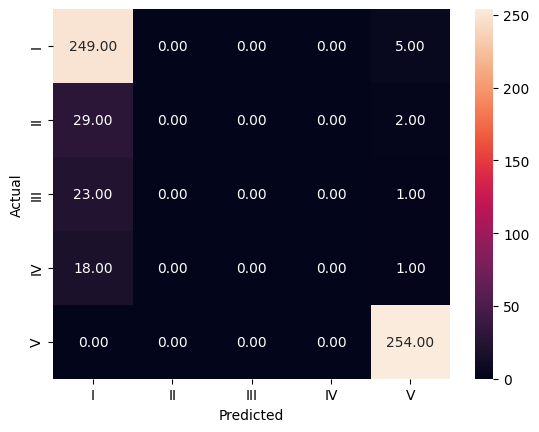


Confusion matrix for testing set:



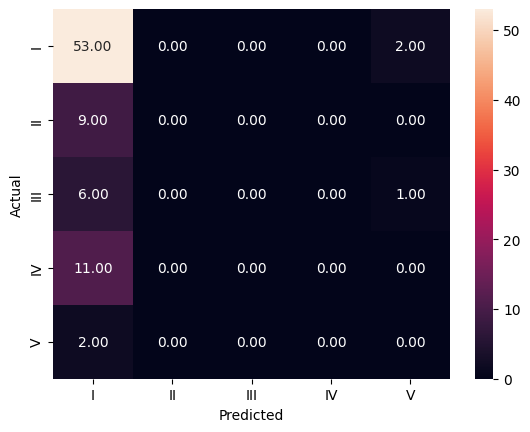

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           I       0.78      0.98      0.87       254
          II       0.00      0.00      0.00        31
         III       0.00      0.00      0.00        24
          IV       0.00      0.00      0.00        19
           V       0.97      1.00      0.98       254

    accuracy                           0.86       582
   macro avg       0.35      0.40      0.37       582
weighted avg       0.76      0.86      0.81       582


Classification report for Testing set:

              precision    recall  f1-score   support

           I       0.65      0.96      0.78        55
          II       0.00      0.00      0.00         9
         III       0.00      0.00      0.00         7
          IV       0.00      0.00      0.00        11
           V       0.00      0.00      0.00         2

    accuracy                 

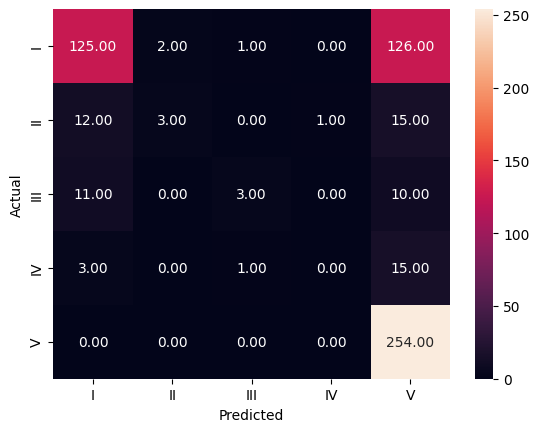


Confusion matrix for testing set:



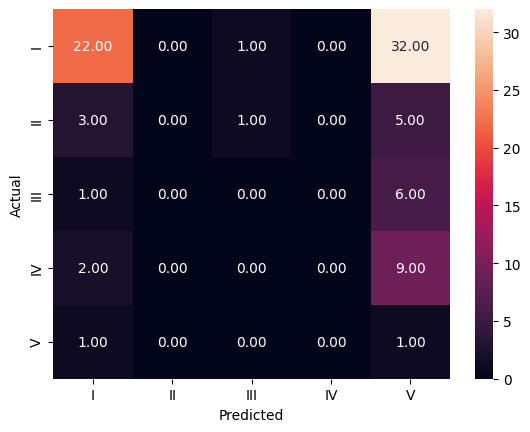

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           I       0.83      0.49      0.62       254
          II       0.60      0.10      0.17        31
         III       0.60      0.12      0.21        24
          IV       0.00      0.00      0.00        19
           V       0.60      1.00      0.75       254

    accuracy                           0.66       582
   macro avg       0.53      0.34      0.35       582
weighted avg       0.68      0.66      0.62       582


Classification report for Testing set:

              precision    recall  f1-score   support

           I       0.76      0.40      0.52        55
          II       0.00      0.00      0.00         9
         III       0.00      0.00      0.00         7
          IV       0.00      0.00      0.00        11
           V       0.02      0.50      0.04         2

    accuracy                 

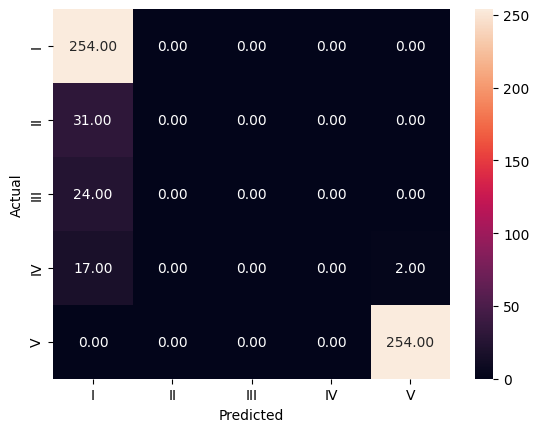


Confusion matrix for testing set:



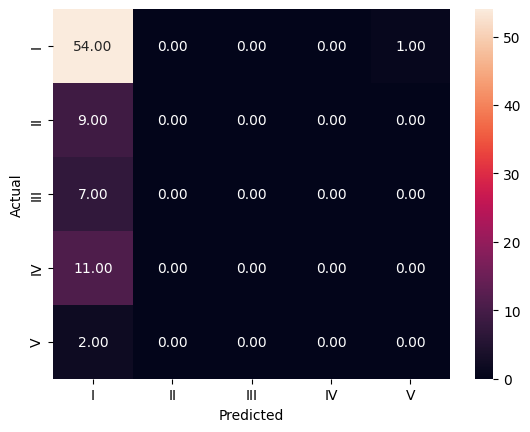

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           I       0.78      1.00      0.88       254
          II       0.00      0.00      0.00        31
         III       0.00      0.00      0.00        24
          IV       0.00      0.00      0.00        19
           V       0.99      1.00      1.00       254

    accuracy                           0.87       582
   macro avg       0.35      0.40      0.37       582
weighted avg       0.77      0.87      0.82       582


Classification report for Testing set:

              precision    recall  f1-score   support

           I       0.65      0.98      0.78        55
          II       0.00      0.00      0.00         9
         III       0.00      0.00      0.00         7
          IV       0.00      0.00      0.00        11
           V       0.00      0.00      0.00         2

    accuracy                 

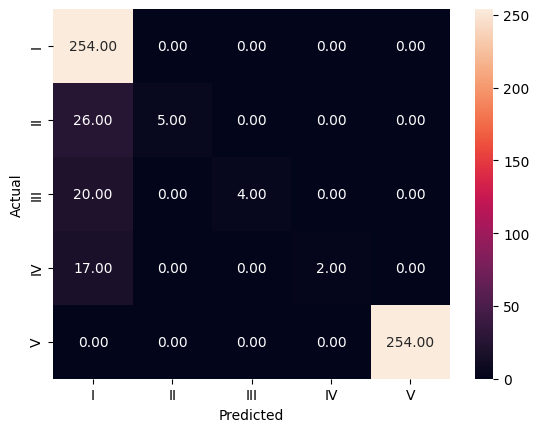


Confusion matrix for testing set:



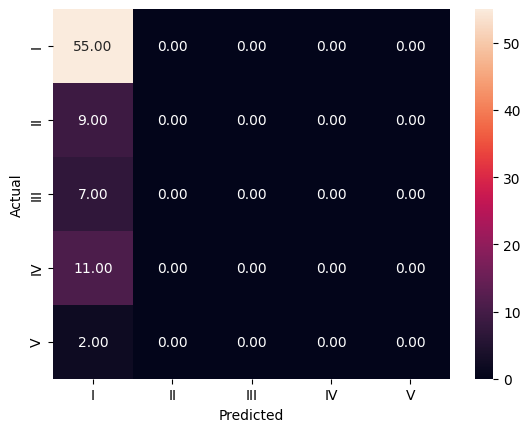

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           I       0.80      1.00      0.89       254
          II       1.00      0.16      0.28        31
         III       1.00      0.17      0.29        24
          IV       1.00      0.11      0.19        19
           V       1.00      1.00      1.00       254

    accuracy                           0.89       582
   macro avg       0.96      0.49      0.53       582
weighted avg       0.91      0.89      0.86       582


Classification report for Testing set:

              precision    recall  f1-score   support

           I       0.65      1.00      0.79        55
          II       0.00      0.00      0.00         9
         III       0.00      0.00      0.00         7
          IV       0.00      0.00      0.00        11
           V       0.00      0.00      0.00         2

    accuracy                 

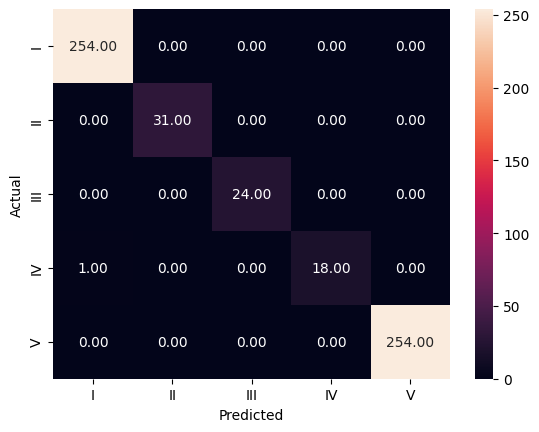


Confusion matrix for testing set:



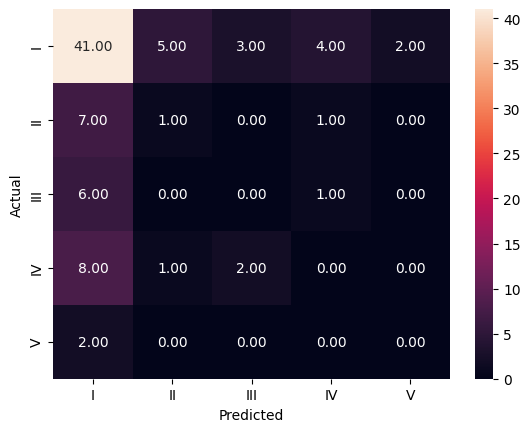

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           I       1.00      1.00      1.00       254
          II       1.00      1.00      1.00        31
         III       1.00      1.00      1.00        24
          IV       1.00      0.95      0.97        19
           V       1.00      1.00      1.00       254

    accuracy                           1.00       582
   macro avg       1.00      0.99      0.99       582
weighted avg       1.00      1.00      1.00       582


Classification report for Testing set:

              precision    recall  f1-score   support

           I       0.64      0.75      0.69        55
          II       0.14      0.11      0.12         9
         III       0.00      0.00      0.00         7
          IV       0.00      0.00      0.00        11
           V       0.00      0.00      0.00         2

    accuracy                 

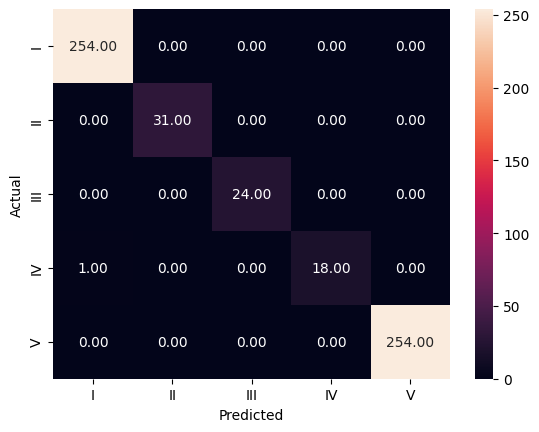


Confusion matrix for testing set:



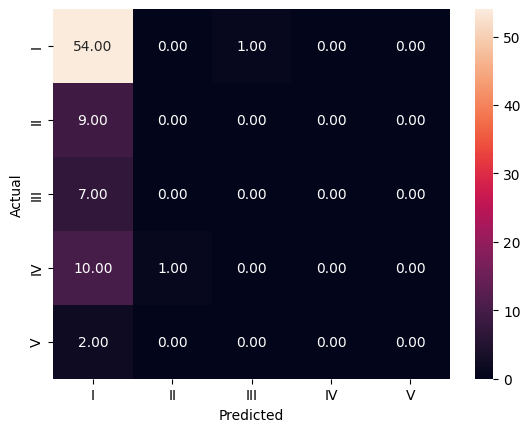

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           I       1.00      1.00      1.00       254
          II       1.00      1.00      1.00        31
         III       1.00      1.00      1.00        24
          IV       1.00      0.95      0.97        19
           V       1.00      1.00      1.00       254

    accuracy                           1.00       582
   macro avg       1.00      0.99      0.99       582
weighted avg       1.00      1.00      1.00       582


Classification report for Testing set:

              precision    recall  f1-score   support

           I       0.66      0.98      0.79        55
          II       0.00      0.00      0.00         9
         III       0.00      0.00      0.00         7
          IV       0.00      0.00      0.00        11
           V       0.00      0.00      0.00         2

    accuracy                 

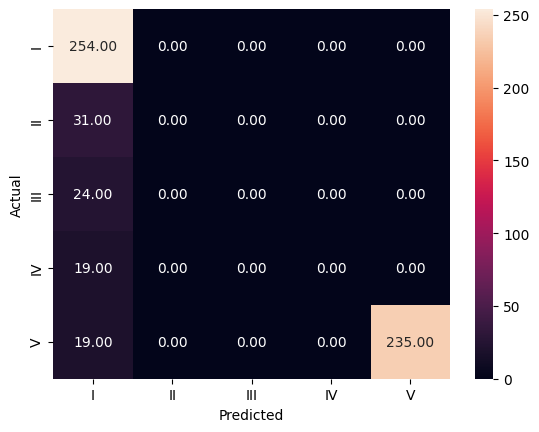


Confusion matrix for testing set:



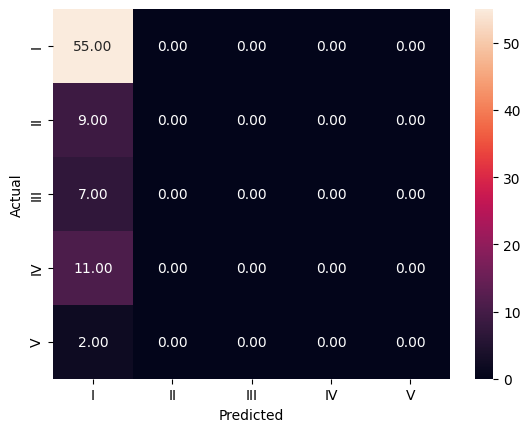

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           I       0.73      1.00      0.85       254
          II       0.00      0.00      0.00        31
         III       0.00      0.00      0.00        24
          IV       0.00      0.00      0.00        19
           V       1.00      0.93      0.96       254

    accuracy                           0.84       582
   macro avg       0.35      0.39      0.36       582
weighted avg       0.76      0.84      0.79       582


Classification report for Testing set:

              precision    recall  f1-score   support

           I       0.65      1.00      0.79        55
          II       0.00      0.00      0.00         9
         III       0.00      0.00      0.00         7
          IV       0.00      0.00      0.00        11
           V       0.00      0.00      0.00         2

    accuracy                 

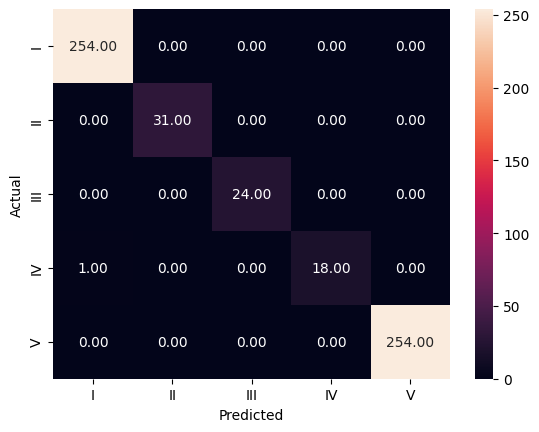


Confusion matrix for testing set:



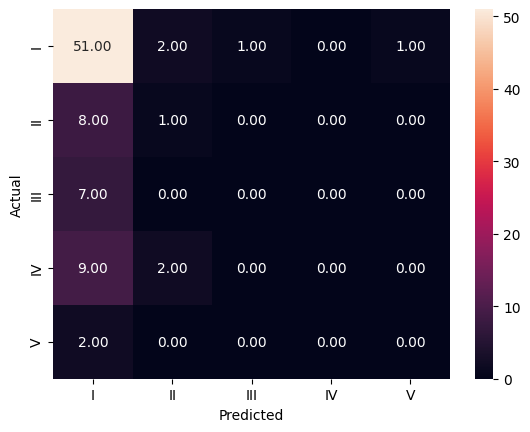

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           I       1.00      1.00      1.00       254
          II       1.00      1.00      1.00        31
         III       1.00      1.00      1.00        24
          IV       1.00      0.95      0.97        19
           V       1.00      1.00      1.00       254

    accuracy                           1.00       582
   macro avg       1.00      0.99      0.99       582
weighted avg       1.00      1.00      1.00       582


Classification report for Testing set:

              precision    recall  f1-score   support

           I       0.66      0.93      0.77        55
          II       0.20      0.11      0.14         9
         III       0.00      0.00      0.00         7
          IV       0.00      0.00      0.00        11
           V       0.00      0.00      0.00         2

    accuracy                 

In [ ]:
#Training all the moddels
train_test(models_sampling,x_train_sample,y_train_sample,x_test,y_test)

In [ ]:
# Function to get the metrics score
def get_metrics_score_sample(model):

  score_list = []

  pred_train = model.predict(x_train_sample)

  pred_test = model.predict(x_test)

  train_acc = round(model.score(x_train_sample,y_train_sample)*100,2)
  test_acc = round(model.score(x_test,y_test)*100,2)

  train_recall = round(recall_score(y_train_sample,pred_train,average='weighted')*100,2)
  test_recall = round(recall_score(y_test,pred_test,average='weighted')*100,2)

  train_precision = round(precision_score(y_train_sample,pred_train,average='weighted')*100,2)
  test_precision = round(precision_score(y_test,pred_test,average='weighted')*100,2)

  train_f1 = round(f1_score(y_train_sample,pred_train,average='weighted')*100,2)
  test_f1 = round(f1_score(y_test,pred_test,average='weighted')*100,2)

  score_list.append([train_acc,test_acc,train_recall,test_recall,train_precision,test_precision,train_f1,test_f1])

  return score_list

In [ ]:
#Creating empty list to add train and test results
methods = []
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []
f1_train = []
f1_test = []
#looping through the models
for name,model in models_sampling.items():
  methods.append(name)
  j = get_metrics_score_sample(model)
  acc_train.append((j[0][0]))
  acc_test.append((j[0][1]))
  recall_train.append((j[0][2]))
  recall_test.append((j[0][3]))
  precision_train.append((j[0][4]))
  precision_test.append((j[0][5]))
  f1_train.append((j[0][6]))
  f1_test.append((j[0][7]))

In [ ]:
#Creating Dataframe
comparison_frame = pd.DataFrame({'Methods':methods,
                                          'Train_Accuracy': acc_train,'Test_Accuracy': acc_test,
                                          'Train_Recall':recall_train,'Test_Recall':recall_test,
                                          'Train_Precision':precision_train,'Test_Precision':precision_test,
                                          'Train_F1':f1_train,
                                          'Test_F1':f1_test  })

#Sorting models in decreasing order of test accuracy
comparison_frame.sort_values(by='Test_F1',ascending=False)

,Methods,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision,Train_F1,Test_F1
7,Gradient Boost with Sampling,99.83,61.90,99.83,61.90,99.83,45.51,99.83,52.13
3,SVM with Sampling,89.18,65.48,89.18,65.48,91.33,42.87,85.75,51.82
6,Ada Boost with Sampling,84.02,65.48,84.02,65.48,75.59,42.87,78.84,51.82
5,Random Forest with Sampling,99.83,64.29,99.83,64.29,99.83,43.12,99.83,51.62
2,Logistic Regression with Sampling,87.29,64.29,87.29,64.29,77.31,42.60,81.70,51.24
0,Naive Bayes with Sampling,86.43,63.10,86.43,63.10,76.22,42.84,80.81,51.03
4,Decision Tree with Sampling,99.83,50.00,99.83,50.00,99.83,43.48,99.83,46.46
1,KNearest Neighbor with Sampling,66.15,27.38,66.15,27.38,68.19,49.72,61.57,34.38


# Tunning the model

Naive Bayes

In [ ]:
params_nb = {'alpha':np.logspace(0,-9, num=10)}
nb_param = hyperparameter_tunning(models_sampling['Naive Bayes with Sampling'],x_train_sample,y_train_sample,params_nb)

Best Score:  0.8608458591217213
Best Parameter: {'alpha': 0.1}
95% Confidence interval range: (0.8338 %, 0.8879 %)


KNearest Neighbor

In [ ]:
params_knn = {'leaf_size':list(range(1,100)),'n_neighbors':list(range(3, 16, 2)),'weights' : ['uniform', 'distance'],'metric' : ['euclidean', 'manhattan']}
knn_param = hyperparameter_tunning(models_sampling['KNearest Neighbor with Sampling'],x_train_sample,y_train_sample,params_knn)

Best Score:  0.8625552608311228
Best Parameter: {'leaf_size': 1, 'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}
95% Confidence interval range: (0.8441 %, 0.8810 %)


Logistic Regression

In [ ]:
params_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l2'],
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']
}
lr_param = hyperparameter_tunning(models_sampling['Logistic Regression with Sampling'],x_train_sample,y_train_sample,params_lr)

Best Score:  0.8728558797524315
Best Parameter: {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}
95% Confidence interval range: (0.8663 %, 0.8794 %)


SVM

In [ ]:
params_svm = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
svm_param = hyperparameter_tunning(models_sampling['SVM with Sampling'],x_train_sample,y_train_sample,params_svm)

Best Score:  0.8728558797524315
Best Parameter: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
95% Confidence interval range: (0.8663 %, 0.8794 %)


Decision Tree

In [ ]:
params_dt = {'max_depth': [2, 3, 5, 7, 10,15, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100, 200, 300],
    'criterion': ["gini", "entropy"]}
dt_param = hyperparameter_tunning(models_sampling['Decision Tree with Sampling'],x_train_sample,y_train_sample,params_dt)

Best Score:  0.8642941349837902
Best Parameter: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 10}
95% Confidence interval range: (0.8424 %, 0.8862 %)


Random Forest

In [ ]:
params_rf = {'n_estimators': [150,200,250],
    'max_features':[0.2,0.3,0.4,0.5,0.6],
    'max_samples': [0.3,0.4,0.5,0.6]}
rf_param = hyperparameter_tunning(models_sampling['Random Forest with Sampling'],x_train_sample,y_train_sample,params_rf)

Best Score:  0.8728558797524315
Best Parameter: {'max_features': 0.2, 'max_samples': 0.3, 'n_estimators': 150}
95% Confidence interval range: (0.8663 %, 0.8794 %)


Ada Boost

In [ ]:
params_ada = {'n_estimators': [50, 100,150,200,250],'algorithm' : ['SAMME','SAMME.R'],
                        'learning_rate':[0.0001, 0.01, 0.1, 1.0, 1.1, 1.2]}
ada_param = hyperparameter_tunning(models_sampling['Ada Boost with Sampling'],x_train_sample,y_train_sample,params_ada)

Best Score:  0.8677276746242264
Best Parameter: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 100}
95% Confidence interval range: (0.8512 %, 0.8843 %)


Gradient Boost

In [ ]:
params_gb = {'n_estimators': [100, 150,200],'max_depth':np.arange(3,7,1),
                         'max_features':np.arange(0.2,0.6,0.1)
                        }
gb_param = hyperparameter_tunning(models_sampling['Gradient Boost with Sampling'],x_train_sample,y_train_sample,params_gb)

Best Score:  0.8402151488358385
Best Parameter: {'max_depth': 6, 'max_features': 0.30000000000000004, 'n_estimators': 150}
95% Confidence interval range: (0.7946 %, 0.8858 %)


# Training the Tuneed models after sampling

In [ ]:
#Defining the models
models_sampling_tunned = dict({'Tunned Naive Bayes with Sampling':MultinomialNB(**nb_param),'Tunned KNearest Neighbor with Sampling':KNeighborsClassifier(**knn_param),'Tunned Logistic Regression with Sampling':LogisticRegression(**lr_param),
               'Tunned SVM with Sampling':SVC(**svm_param),'Tunned Decision Tree with Sampling':DecisionTreeClassifier(**dt_param),'Tunned Random Forest with Sampling':RandomForestClassifier(**rf_param),
               'Tunned Ada Boost with Sampling':AdaBoostClassifier(**ada_param),'Tunned Gradient Boost with Sampling':GradientBoostingClassifier(**gb_param)})


Model Name: Tunned Naive Bayes with Sampling

Training Accuracy:  0.9072164948453608
Testing Accuracy:  0.6428571428571429

Confusion matrix for training set:



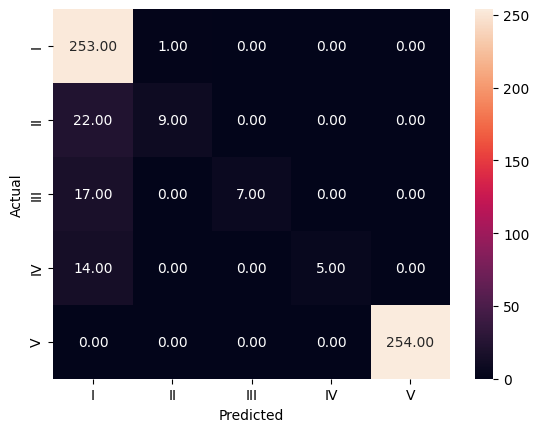


Confusion matrix for testing set:



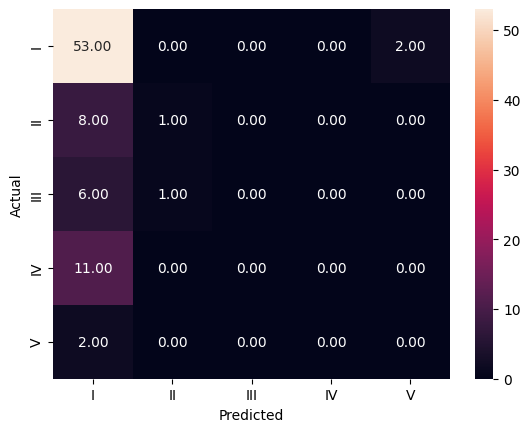

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           I       0.83      1.00      0.90       254
          II       0.90      0.29      0.44        31
         III       1.00      0.29      0.45        24
          IV       1.00      0.26      0.42        19
           V       1.00      1.00      1.00       254

    accuracy                           0.91       582
   macro avg       0.95      0.57      0.64       582
weighted avg       0.92      0.91      0.89       582


Classification report for Testing set:

              precision    recall  f1-score   support

           I       0.66      0.96      0.79        55
          II       0.50      0.11      0.18         9
         III       0.00      0.00      0.00         7
          IV       0.00      0.00      0.00        11
           V       0.00      0.00      0.00         2

    accuracy                 

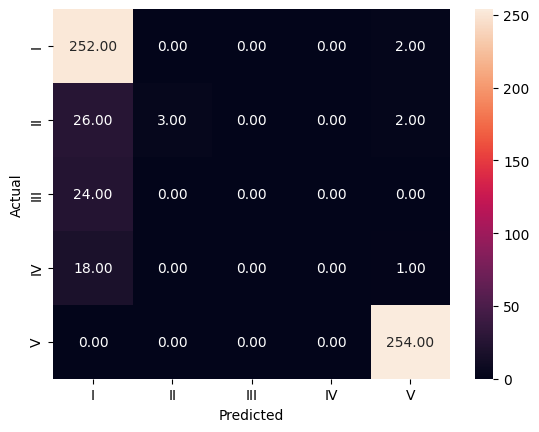


Confusion matrix for testing set:



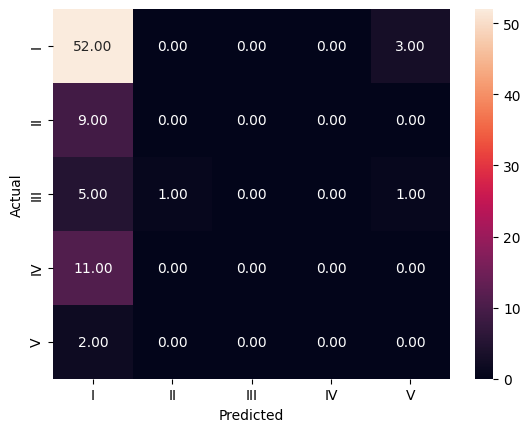

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           I       0.79      0.99      0.88       254
          II       1.00      0.10      0.18        31
         III       0.00      0.00      0.00        24
          IV       0.00      0.00      0.00        19
           V       0.98      1.00      0.99       254

    accuracy                           0.87       582
   macro avg       0.55      0.42      0.41       582
weighted avg       0.82      0.87      0.82       582


Classification report for Testing set:

              precision    recall  f1-score   support

           I       0.66      0.95      0.78        55
          II       0.00      0.00      0.00         9
         III       0.00      0.00      0.00         7
          IV       0.00      0.00      0.00        11
           V       0.00      0.00      0.00         2

    accuracy                 

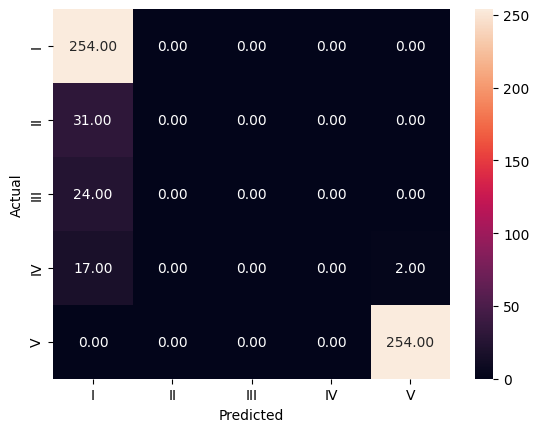


Confusion matrix for testing set:



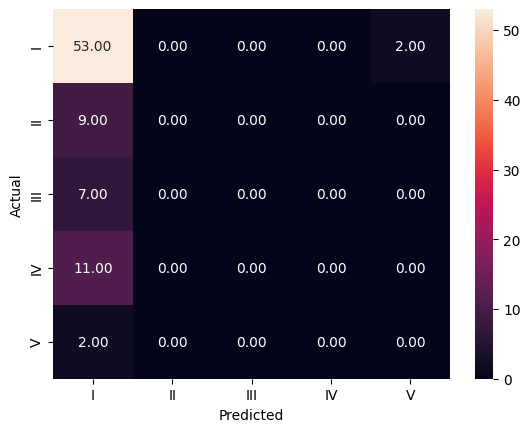

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           I       0.78      1.00      0.88       254
          II       0.00      0.00      0.00        31
         III       0.00      0.00      0.00        24
          IV       0.00      0.00      0.00        19
           V       0.99      1.00      1.00       254

    accuracy                           0.87       582
   macro avg       0.35      0.40      0.37       582
weighted avg       0.77      0.87      0.82       582


Classification report for Testing set:

              precision    recall  f1-score   support

           I       0.65      0.96      0.77        55
          II       0.00      0.00      0.00         9
         III       0.00      0.00      0.00         7
          IV       0.00      0.00      0.00        11
           V       0.00      0.00      0.00         2

    accuracy                 

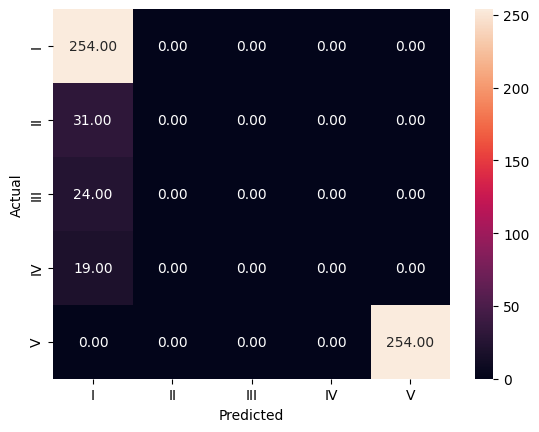


Confusion matrix for testing set:



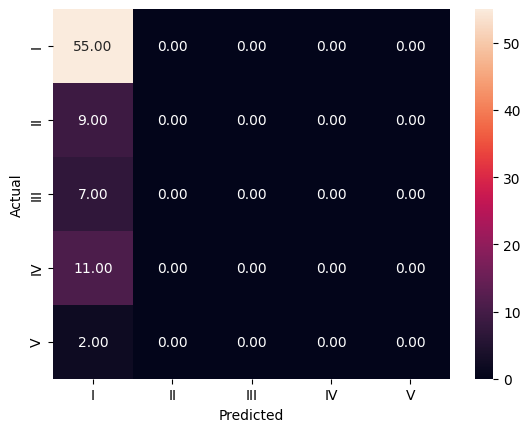

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           I       0.77      1.00      0.87       254
          II       0.00      0.00      0.00        31
         III       0.00      0.00      0.00        24
          IV       0.00      0.00      0.00        19
           V       1.00      1.00      1.00       254

    accuracy                           0.87       582
   macro avg       0.35      0.40      0.37       582
weighted avg       0.77      0.87      0.82       582


Classification report for Testing set:

              precision    recall  f1-score   support

           I       0.65      1.00      0.79        55
          II       0.00      0.00      0.00         9
         III       0.00      0.00      0.00         7
          IV       0.00      0.00      0.00        11
           V       0.00      0.00      0.00         2

    accuracy                 

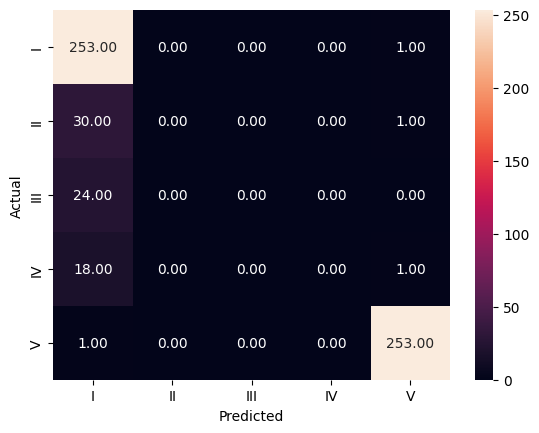


Confusion matrix for testing set:



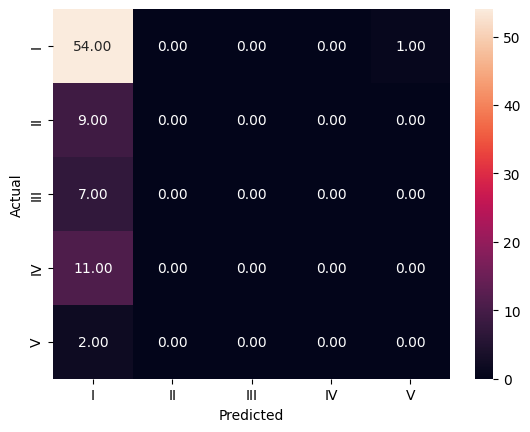

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           I       0.78      1.00      0.87       254
          II       0.00      0.00      0.00        31
         III       0.00      0.00      0.00        24
          IV       0.00      0.00      0.00        19
           V       0.99      1.00      0.99       254

    accuracy                           0.87       582
   macro avg       0.35      0.40      0.37       582
weighted avg       0.77      0.87      0.81       582


Classification report for Testing set:

              precision    recall  f1-score   support

           I       0.65      0.98      0.78        55
          II       0.00      0.00      0.00         9
         III       0.00      0.00      0.00         7
          IV       0.00      0.00      0.00        11
           V       0.00      0.00      0.00         2

    accuracy                 

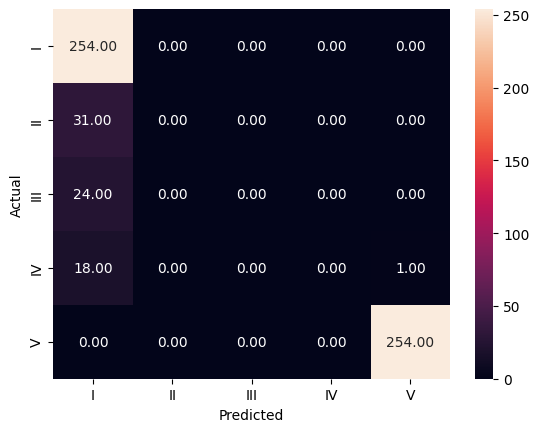


Confusion matrix for testing set:



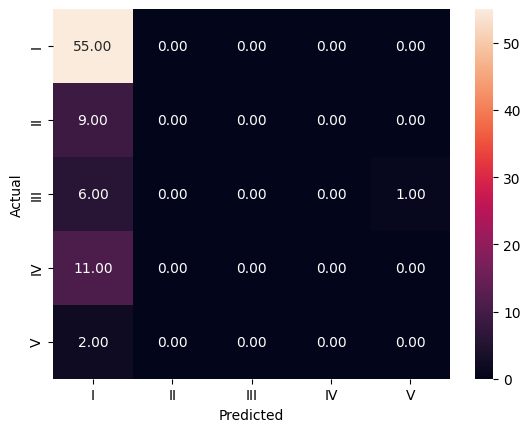

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           I       0.78      1.00      0.87       254
          II       0.00      0.00      0.00        31
         III       0.00      0.00      0.00        24
          IV       0.00      0.00      0.00        19
           V       1.00      1.00      1.00       254

    accuracy                           0.87       582
   macro avg       0.35      0.40      0.37       582
weighted avg       0.77      0.87      0.82       582


Classification report for Testing set:

              precision    recall  f1-score   support

           I       0.66      1.00      0.80        55
          II       0.00      0.00      0.00         9
         III       0.00      0.00      0.00         7
          IV       0.00      0.00      0.00        11
           V       0.00      0.00      0.00         2

    accuracy                 

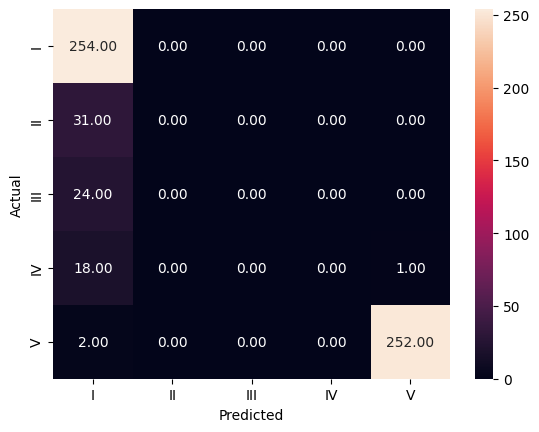


Confusion matrix for testing set:



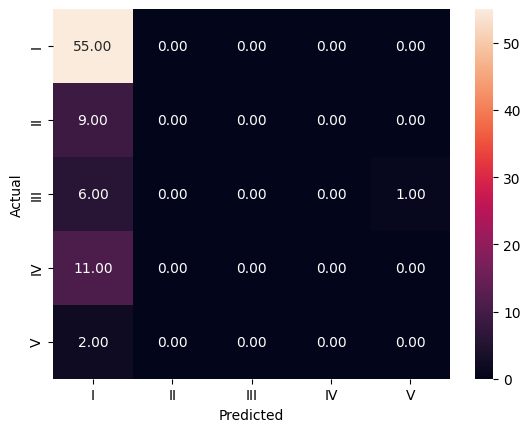

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           I       0.77      1.00      0.87       254
          II       0.00      0.00      0.00        31
         III       0.00      0.00      0.00        24
          IV       0.00      0.00      0.00        19
           V       1.00      0.99      0.99       254

    accuracy                           0.87       582
   macro avg       0.35      0.40      0.37       582
weighted avg       0.77      0.87      0.81       582


Classification report for Testing set:

              precision    recall  f1-score   support

           I       0.66      1.00      0.80        55
          II       0.00      0.00      0.00         9
         III       0.00      0.00      0.00         7
          IV       0.00      0.00      0.00        11
           V       0.00      0.00      0.00         2

    accuracy                 

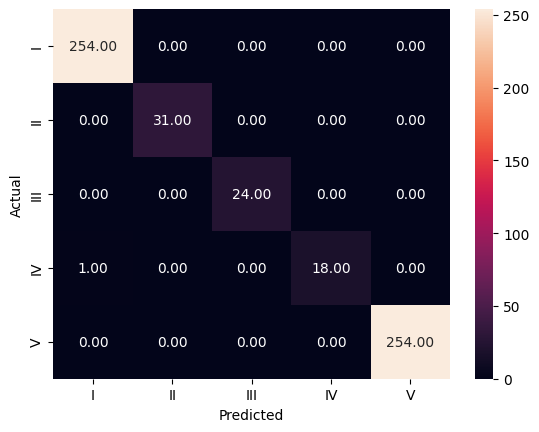


Confusion matrix for testing set:



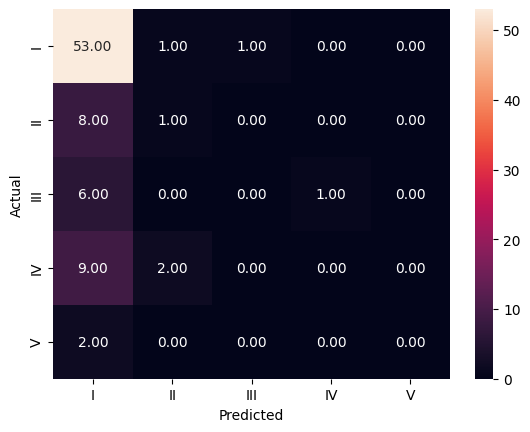

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           I       1.00      1.00      1.00       254
          II       1.00      1.00      1.00        31
         III       1.00      1.00      1.00        24
          IV       1.00      0.95      0.97        19
           V       1.00      1.00      1.00       254

    accuracy                           1.00       582
   macro avg       1.00      0.99      0.99       582
weighted avg       1.00      1.00      1.00       582


Classification report for Testing set:

              precision    recall  f1-score   support

           I       0.68      0.96      0.80        55
          II       0.25      0.11      0.15         9
         III       0.00      0.00      0.00         7
          IV       0.00      0.00      0.00        11
           V       0.00      0.00      0.00         2

    accuracy                 

In [ ]:
#Training the model
train_test(models_sampling_tunned,x_train_sample,y_train_sample,x_test,y_test)

In [ ]:
#Creating empty list to add train and test results
methods = []
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []
f1_train = []
f1_test = []
#looping through the models
for name,model in models_sampling_tunned.items():
  methods.append(name)
  j = get_metrics_score_sample(model)
  acc_train.append((j[0][0]))
  acc_test.append((j[0][1]))
  recall_train.append((j[0][2]))
  recall_test.append((j[0][3]))
  precision_train.append((j[0][4]))
  precision_test.append((j[0][5]))
  f1_train.append((j[0][6]))
  f1_test.append((j[0][7]))

In [ ]:
#Creating Dataframe
comparison_frame = pd.DataFrame({'Methods':methods,
                                          'Train_Accuracy': acc_train,'Test_Accuracy': acc_test,
                                          'Train_Recall':recall_train,'Test_Recall':recall_test,
                                          'Train_Precision':precision_train,'Test_Precision':precision_test,
                                          'Train_F1':f1_train,
                                          'Test_F1':f1_test  })

#Sorting models in decreasing order of test accuracy
comparison_frame.sort_values(by='Test_F1',ascending=False)

,Methods,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision,Train_F1,Test_F1
7,Tunned Gradient Boost with Sampling,99.83,64.29,99.83,64.29,99.83,47.17,99.83,53.83
0,Tunned Naive Bayes with Sampling,90.72,64.29,90.72,64.29,91.91,48.74,88.64,53.36
5,Tunned Random Forest with Sampling,87.29,65.48,87.29,65.48,77.37,43.39,81.72,52.19
6,Tunned Ada Boost with Sampling,86.94,65.48,86.94,65.48,77.16,43.39,81.41,52.19
3,Tunned SVM with Sampling,87.29,65.48,87.29,65.48,77.44,42.87,81.74,51.82
4,Tunned Decision Tree with Sampling,86.94,64.29,86.94,64.29,77.00,42.60,81.37,51.24
1,Tunned KNearest Neighbor with Sampling,87.46,61.90,87.46,61.90,82.50,43.10,82.48,50.82
2,Tunned Logistic Regression with Sampling,87.29,63.10,87.29,63.10,77.31,42.32,81.70,50.66


# Conclusion

* Gradient Boosting Model performs better which has a test f1 score of 55.92%. Also after tunning the model f1 score improved to 55.96%.
* Since the distribution of target variable is highly unbalanced, so trained the models after oversampling of data, achieved f1 score of 52.51%,which further improved to 54.56% after tunning after tunning.
* After comparing all the models we can conclude that gradient boostig algorithm without oversampling performs better which has f1 score of 55.96%.
* Further to improve the model performance and reduce overfitting, we can build neural networks using RNN or LSTM.

# Neural Networks

Data Preprocessing for Neural Networks

In [ ]:
#Vectorization using tfidf
vec = TfidfVectorizer()
x_vec = vec.fit_transform(x).toarray()

In [ ]:
#One hot encoding of target variables
y = pd.get_dummies(y).values

In [ ]:
#Splitting data into train and test set
x_train, x_test, y_train, y_test = train_test_split(x_vec,y,train_size=0.8,random_state=1)

In [ ]:
# Resampling the minority class
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Fit the model to generate the data.
x_train_sample,y_train_sample = sm.fit_resample(x_train, y_train)

# Building Neural Networks 1

In [ ]:
#building Neural nEtworkd
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=15,activation='relu',kernel_initializer='he_uniform'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=20,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(units=12,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(units=10,activation='relu'))
model.add(tf.keras.layers.Dense(units=5,activation='softmax'))

In [ ]:
#Compiling the model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['Accuracy'])
#model.summary()

In [ ]:
#Training the Neural Network
history = model.fit(x_train,y_train,batch_size=12,epochs=100,validation_data=(x_test,y_test))

Epoch 1/100
28/28 [==============================] - 2s 13ms/step - loss: 1.5613 - Accuracy: 0.6228 - val_loss: 1.5202 - val_Accuracy: 0.6548
Epoch 2/100
28/28 [==============================] - 0s 4ms/step - loss: 1.4037 - Accuracy: 0.7605 - val_loss: 1.3384 - val_Accuracy: 0.6548
Epoch 3/100
28/28 [==============================] - 0s 5ms/step - loss: 1.1316 - Accuracy: 0.7605 - val_loss: 1.1142 - val_Accuracy: 0.6548
Epoch 4/100
28/28 [==============================] - 0s 4ms/step - loss: 0.9490 - Accuracy: 0.7605 - val_loss: 1.0952 - val_Accuracy: 0.6548
Epoch 5/100
28/28 [==============================] - 0s 4ms/step - loss: 0.8902 - Accuracy: 0.7605 - val_loss: 1.0875 - val_Accuracy: 0.6548
Epoch 6/100
28/28 [==============================] - 0s 4ms/step - loss: 0.8704 - Accuracy: 0.7605 - val_loss: 1.0883 - val_Accuracy: 0.6548
Epoch 7/100
28/28 [==============================] - 0s 4ms/step - loss: 0.8286 - Accuracy: 0.7605 - val_loss: 1.0815 - val_Accuracy: 0.6548
Epoch 8/100


Text(0.5, 1.0, 'Accuracy vs Val_Accuracy')

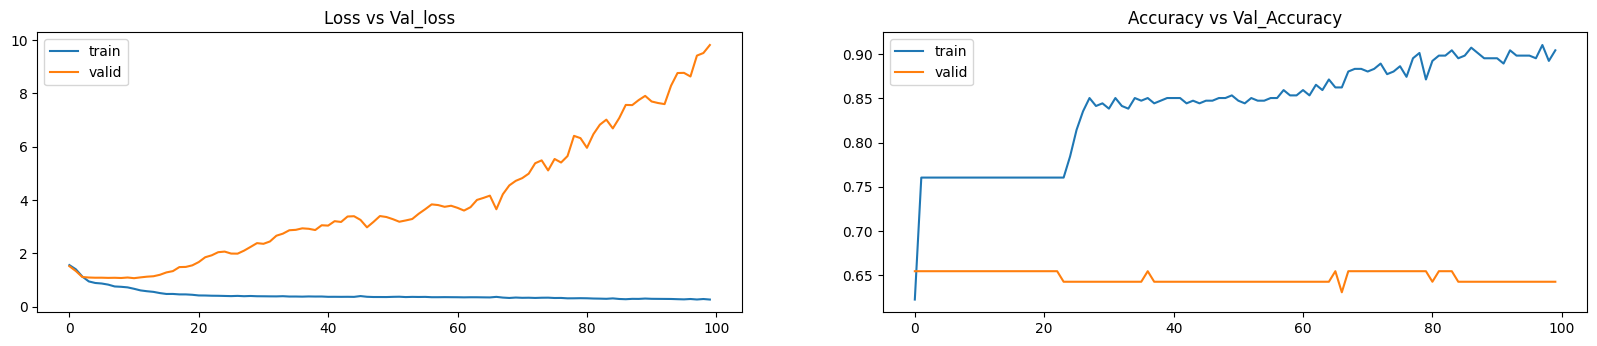

In [ ]:
#Plotting loss and accuracy curve vs epochs
plt.figure(figsize=(20,8))
plt.subplot(2,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(("train" , "valid") , loc =0)
plt.title("Loss vs Val_loss")
plt.subplot(2,2,2)
plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.legend(("train" , "valid") , loc =0)
plt.title("Accuracy vs Val_Accuracy")

In [ ]:
#Creating function to display evaluation matrix
def evaluation_matrix(model, x_train,y_train,x_test,y_test):
  y_train_pred = np.argmax(model.predict(x_train),axis=1)+1
  y_test_pred = np.argmax(model.predict(x_test),axis=1)+1
  train_recall = round(recall_score(np.argmax(y_train,axis=1)+1,y_train_pred,average='weighted')*100,2)
  test_recall = round(recall_score(np.argmax(y_test,axis=1)+1,y_test_pred,average='weighted')*100,2)

  train_precision = round(precision_score(np.argmax(y_train,axis=1)+1,y_train_pred,average='weighted')*100,2)
  test_precision = round(precision_score(np.argmax(y_test,axis=1)+1,y_test_pred,average='weighted')*100,2)

  train_f1 = round(f1_score(np.argmax(y_train,axis=1)+1,y_train_pred,average='weighted')*100,2)
  test_f1 = round(f1_score(np.argmax(y_test,axis=1)+1,y_test_pred,average='weighted')*100,2)
  print('Train Recall:',train_recall)
  print('Test Recall:',test_recall)
  print('Train Precision:',train_precision)
  print('Test Precision:',test_precision)
  print('Train F1:',train_f1)
  print('Test F1:',test_f1)



  print('\nConfusion matrix for training set:\n')
  model_cm_train = confusion_matrix(np.argmax(y_train,axis=1)+1, y_train_pred)
  sns.heatmap(model_cm_train, annot=True,  fmt='.2f', xticklabels = ["1", "2", "3", "4","5"] , yticklabels = ["1", "2", "3", "4","5"] )
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()

  print('\nConfusion matrix for testing set:\n')
  model_cm_test = confusion_matrix(np.argmax(y_test,axis=1)+1, y_test_pred)
  sns.heatmap(model_cm_test, annot=True,  fmt='.2f', xticklabels = ["1", "2", "3", "4","5"] , yticklabels = ["1", "2", "3", "4","5"]  )
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()
  print('************************************************************************')
  print('\nClassification report for Training set:\n')
  print(classification_report(np.argmax(y_train,axis=1)+1,y_train_pred))

  print('\nClassification report for Testing set:\n')
  print(classification_report(np.argmax(y_test,axis=1)+1,y_test_pred))
  print('************************************************************************')

3/3 [==============================] - 0s 4ms/step
Train Recall: 91.92
Test Recall: 64.29
Train Precision: 87.82
Test Precision: 46.16
Train F1: 89.26
Test F1: 53.57

Confusion matrix for training set:



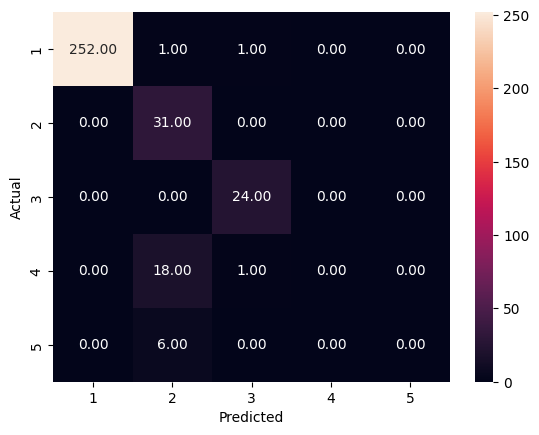


Confusion matrix for testing set:



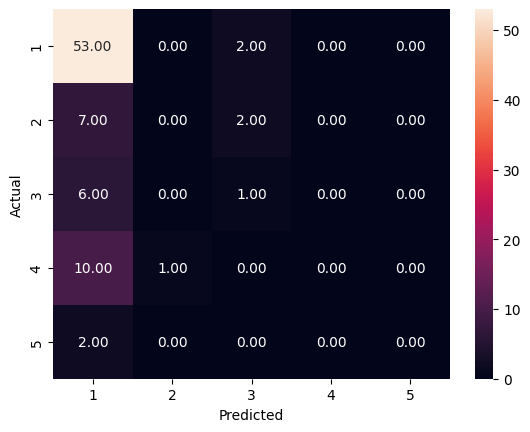

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           1       1.00      0.99      1.00       254
           2       0.55      1.00      0.71        31
           3       0.92      1.00      0.96        24
           4       0.00      0.00      0.00        19
           5       0.00      0.00      0.00         6

    accuracy                           0.92       334
   macro avg       0.50      0.60      0.53       334
weighted avg       0.88      0.92      0.89       334


Classification report for Testing set:

              precision    recall  f1-score   support

           1       0.68      0.96      0.80        55
           2       0.00      0.00      0.00         9
           3       0.20      0.14      0.17         7
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00         2

    accuracy                 

In [ ]:
evaluation_matrix(model,x_train,y_train,x_test,y_test)

In [ ]:
model.save('/content/drive/My Drive/model_chatbot.h5')

In [ ]:
filename_model = "/content/drive/My Drive/model_chatbot.pickle"
pickle.dump(model, open(filename_model, 'wb'))

Test f1 score of the models goes down. Also the model is overfitting. Lets try another neural network.

# Building Neural Network 2

In [ ]:
#building Neural nEtworks 2
model1 = tf.keras.models.Sequential()
model1.add(tf.keras.layers.Dense(units=25,activation='relu',kernel_initializer='he_uniform'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Dropout(0.2))
model1.add(tf.keras.layers.Dense(units=30,activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Dropout(0.2))
model1.add(tf.keras.layers.Dense(units=30,activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Dropout(0.2))
model1.add(tf.keras.layers.Dense(units=15,activation='relu'))
model1.add(tf.keras.layers.Dense(units=5,activation='softmax'))

In [ ]:
#Compiling the model
model1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['Accuracy'])

In [ ]:
#Training the Neural Network
history = model1.fit(x_train,y_train,batch_size=6,epochs=100,validation_data=(x_test,y_test))

Epoch 1/100
56/56 [==============================] - 4s 9ms/step - loss: 2.0883 - Accuracy: 0.1497 - val_loss: 1.5325 - val_Accuracy: 0.6548
Epoch 2/100
56/56 [==============================] - 0s 4ms/step - loss: 1.4815 - Accuracy: 0.3832 - val_loss: 1.4307 - val_Accuracy: 0.6548
Epoch 3/100
56/56 [==============================] - 0s 4ms/step - loss: 1.0980 - Accuracy: 0.5988 - val_loss: 1.2873 - val_Accuracy: 0.6548
Epoch 4/100
56/56 [==============================] - 0s 4ms/step - loss: 0.9777 - Accuracy: 0.6976 - val_loss: 1.1825 - val_Accuracy: 0.6548
Epoch 5/100
56/56 [==============================] - 0s 5ms/step - loss: 0.8854 - Accuracy: 0.7365 - val_loss: 1.1493 - val_Accuracy: 0.6548
Epoch 6/100
56/56 [==============================] - 0s 4ms/step - loss: 0.8105 - Accuracy: 0.7545 - val_loss: 1.1324 - val_Accuracy: 0.6548
Epoch 7/100
56/56 [==============================] - 0s 4ms/step - loss: 0.8195 - Accuracy: 0.7545 - val_loss: 1.1312 - val_Accuracy: 0.6548
Epoch 8/100
5

Text(0.5, 1.0, 'Accuracy vs Val_Accuracy')

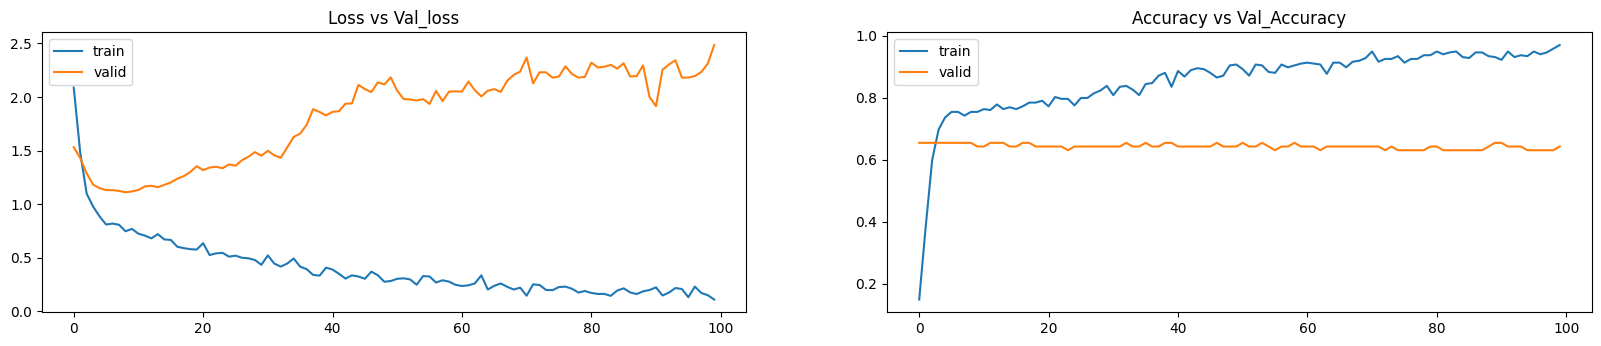

In [ ]:
#Plotting loss and accuracy curve vs epochs
plt.figure(figsize=(20,8))
plt.subplot(2,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(("train" , "valid") , loc =0)
plt.title("Loss vs Val_loss")
plt.subplot(2,2,2)
plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.legend(("train" , "valid") , loc =0)
plt.title("Accuracy vs Val_Accuracy")

3/3 [==============================] - 0s 5ms/step
Train Recall: 99.4
Test Recall: 64.29
Train Precision: 99.42
Test Precision: 44.2
Train F1: 99.4
Test F1: 52.38

Confusion matrix for training set:



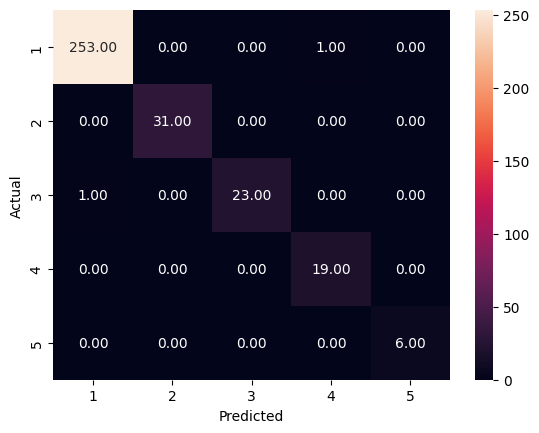


Confusion matrix for testing set:



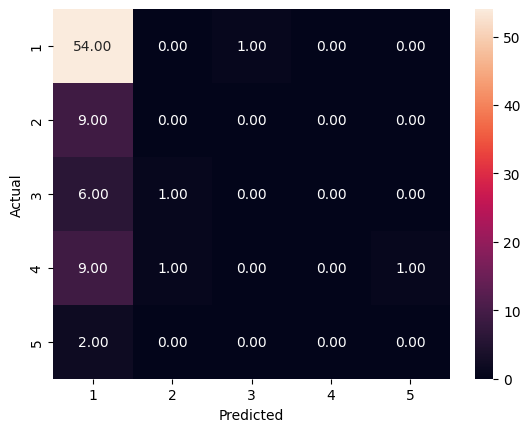

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       254
           2       1.00      1.00      1.00        31
           3       1.00      0.96      0.98        24
           4       0.95      1.00      0.97        19
           5       1.00      1.00      1.00         6

    accuracy                           0.99       334
   macro avg       0.99      0.99      0.99       334
weighted avg       0.99      0.99      0.99       334


Classification report for Testing set:

              precision    recall  f1-score   support

           1       0.68      0.98      0.80        55
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00         2

    accuracy                 

In [ ]:
evaluation_matrix(model1,x_train,y_train,x_test,y_test)

In [ ]:
model1.save('/content/drive/My Drive/model_chatbot1.h5')

In [ ]:
filename_model1 = "/content/drive/My Drive/model_chatbot1.pickle"
pickle.dump(model1, open(filename_model1, 'wb'))

# Building Neural Network 3

In [ ]:
#building Neural nEtworks 3
param=1e-4
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Dense(units=15,activation='relu',kernel_initializer='he_uniform',kernel_regularizer=l2(param),
                kernel_constraint=unit_norm()))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Dropout(0.5))
model2.add(tf.keras.layers.Dense(units=15,activation='relu',kernel_initializer='he_uniform',kernel_regularizer=l2(param),
                kernel_constraint=unit_norm()))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Dropout(0.5))
model2.add(tf.keras.layers.Dense(units=10,activation='relu',kernel_initializer='he_uniform',kernel_regularizer=l2(param),
                kernel_constraint=unit_norm()))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Dropout(0.5))
model2.add(tf.keras.layers.Dense(units=10,activation='relu',kernel_initializer='he_uniform',kernel_regularizer=l2(param),
                kernel_constraint=unit_norm()))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Dropout(0.5))
model2.add(tf.keras.layers.Dense(units=5,activation='softmax',kernel_regularizer=l2(param),
                kernel_constraint=unit_norm()))

In [ ]:
#Compiling the model
model2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['Accuracy'])

In [ ]:
#Training the Neural Network
history = model2.fit(x_train,y_train,batch_size=8,epochs=100,validation_data=(x_test,y_test))

Epoch 1/100
42/42 [==============================] - 3s 11ms/step - loss: 2.1964 - Accuracy: 0.2036 - val_loss: 1.5979 - val_Accuracy: 0.1071
Epoch 2/100
42/42 [==============================] - 0s 5ms/step - loss: 2.1191 - Accuracy: 0.2455 - val_loss: 1.5400 - val_Accuracy: 0.1786
Epoch 3/100
42/42 [==============================] - 0s 4ms/step - loss: 1.9847 - Accuracy: 0.2515 - val_loss: 1.4649 - val_Accuracy: 0.6548
Epoch 4/100
42/42 [==============================] - 0s 4ms/step - loss: 1.8382 - Accuracy: 0.3263 - val_loss: 1.3825 - val_Accuracy: 0.6548
Epoch 5/100
42/42 [==============================] - 0s 4ms/step - loss: 1.7582 - Accuracy: 0.3383 - val_loss: 1.3283 - val_Accuracy: 0.6548
Epoch 6/100
42/42 [==============================] - 0s 5ms/step - loss: 1.5789 - Accuracy: 0.3892 - val_loss: 1.2693 - val_Accuracy: 0.6548
Epoch 7/100
42/42 [==============================] - 0s 4ms/step - loss: 1.3460 - Accuracy: 0.5030 - val_loss: 1.2226 - val_Accuracy: 0.6548
Epoch 8/100


Text(0.5, 1.0, 'Accuracy vs Val_Accuracy')

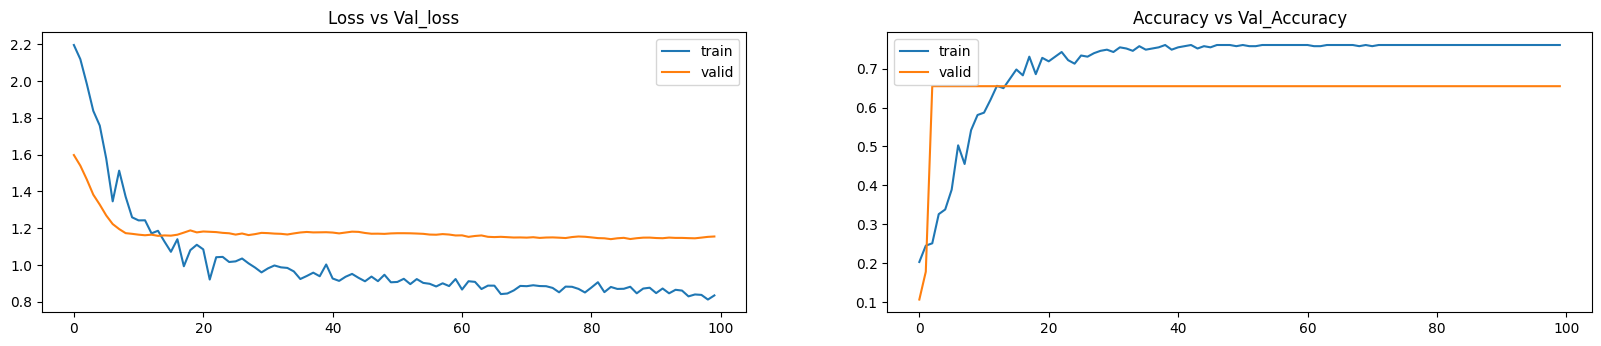

In [ ]:
#Plotting loss and accuracy curve vs epochs
plt.figure(figsize=(20,8))
plt.subplot(2,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(("train" , "valid") , loc =0)
plt.title("Loss vs Val_loss")
plt.subplot(2,2,2)
plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.legend(("train" , "valid") , loc =0)
plt.title("Accuracy vs Val_Accuracy")

3/3 [==============================] - 0s 4ms/step
Train Recall: 76.05
Test Recall: 65.48
Train Precision: 57.83
Test Precision: 42.87
Train F1: 65.7
Test F1: 51.82

Confusion matrix for training set:



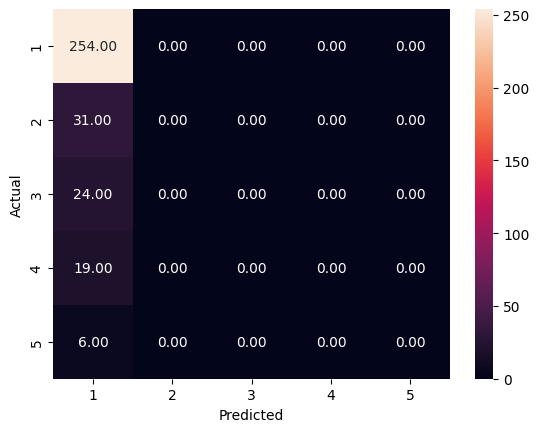


Confusion matrix for testing set:



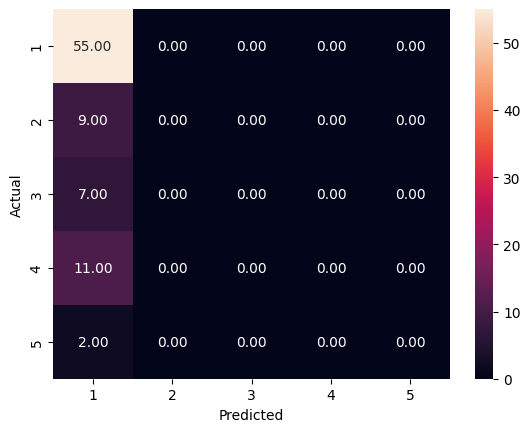

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           1       0.76      1.00      0.86       254
           2       0.00      0.00      0.00        31
           3       0.00      0.00      0.00        24
           4       0.00      0.00      0.00        19
           5       0.00      0.00      0.00         6

    accuracy                           0.76       334
   macro avg       0.15      0.20      0.17       334
weighted avg       0.58      0.76      0.66       334


Classification report for Testing set:

              precision    recall  f1-score   support

           1       0.65      1.00      0.79        55
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00         2

    accuracy                 

In [ ]:
evaluation_matrix(model2,x_train,y_train,x_test,y_test)

In [ ]:
#saving the model
model2.save('/content/drive/My Drive/model_chatbot2.h5')

In [ ]:
#Pickling the model using pickle
filename_model2 = "/content/drive/My Drive/model_chatbot2.pickle"
pickle.dump(model2, open(filename_model2, 'wb'))

Training the model with SMOTE data

In [ ]:
#building Neural nEtworks 3
param=1e-4
model3 = tf.keras.models.Sequential()
model3.add(tf.keras.layers.Dense(units=10,activation='relu',kernel_initializer='he_uniform',kernel_regularizer=l2(param),
                kernel_constraint=unit_norm()))
model3.add(tf.keras.layers.BatchNormalization())
model3.add(tf.keras.layers.Dropout(0.5))
model3.add(tf.keras.layers.Dense(units=20,activation='relu',kernel_initializer='he_uniform',kernel_regularizer=l2(param),
                kernel_constraint=unit_norm()))
model3.add(tf.keras.layers.BatchNormalization())
model3.add(tf.keras.layers.Dropout(0.5))
model3.add(tf.keras.layers.Dense(units=30,activation='relu',kernel_initializer='he_uniform',kernel_regularizer=l2(param),
                kernel_constraint=unit_norm()))
model3.add(tf.keras.layers.BatchNormalization())
model3.add(tf.keras.layers.Dropout(0.5))
model3.add(tf.keras.layers.Dense(units=20,activation='relu',kernel_initializer='he_uniform',kernel_regularizer=l2(param),
                kernel_constraint=unit_norm()))
model3.add(tf.keras.layers.BatchNormalization())
model3.add(tf.keras.layers.Dropout(0.5))
model3.add(tf.keras.layers.Dense(units=10,activation='relu',kernel_initializer='he_uniform',kernel_regularizer=l2(param),
                kernel_constraint=unit_norm()))
model3.add(tf.keras.layers.BatchNormalization())
model3.add(tf.keras.layers.Dropout(0.5))
model3.add(tf.keras.layers.Dense(units=5,activation='softmax',kernel_regularizer=l2(param),
                kernel_constraint=unit_norm()))

In [ ]:
#Compiling the model
model3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['Accuracy'])

In [ ]:
#Training the Neural Network
history = model3.fit(x_train_sample,y_train_sample,batch_size=12,epochs=100,validation_data=(x_test,y_test))

Epoch 1/100
49/49 [==============================] - 5s 10ms/step - loss: 2.0288 - Accuracy: 0.2096 - val_loss: 1.4615 - val_Accuracy: 0.6548
Epoch 2/100
49/49 [==============================] - 0s 5ms/step - loss: 1.9366 - Accuracy: 0.2595 - val_loss: 1.3706 - val_Accuracy: 0.6548
Epoch 3/100
49/49 [==============================] - 0s 5ms/step - loss: 1.8017 - Accuracy: 0.2990 - val_loss: 1.3149 - val_Accuracy: 0.6548
Epoch 4/100
49/49 [==============================] - 0s 4ms/step - loss: 1.7198 - Accuracy: 0.2955 - val_loss: 1.3022 - val_Accuracy: 0.6548
Epoch 5/100
49/49 [==============================] - 0s 5ms/step - loss: 1.5380 - Accuracy: 0.3591 - val_loss: 1.2952 - val_Accuracy: 0.6548
Epoch 6/100
49/49 [==============================] - 0s 4ms/step - loss: 1.5277 - Accuracy: 0.3711 - val_loss: 1.2907 - val_Accuracy: 0.6548
Epoch 7/100
49/49 [==============================] - 0s 5ms/step - loss: 1.5205 - Accuracy: 0.3797 - val_loss: 1.3029 - val_Accuracy: 0.6548
Epoch 8/100


Text(0.5, 1.0, 'Accuracy vs Val_Accuracy')

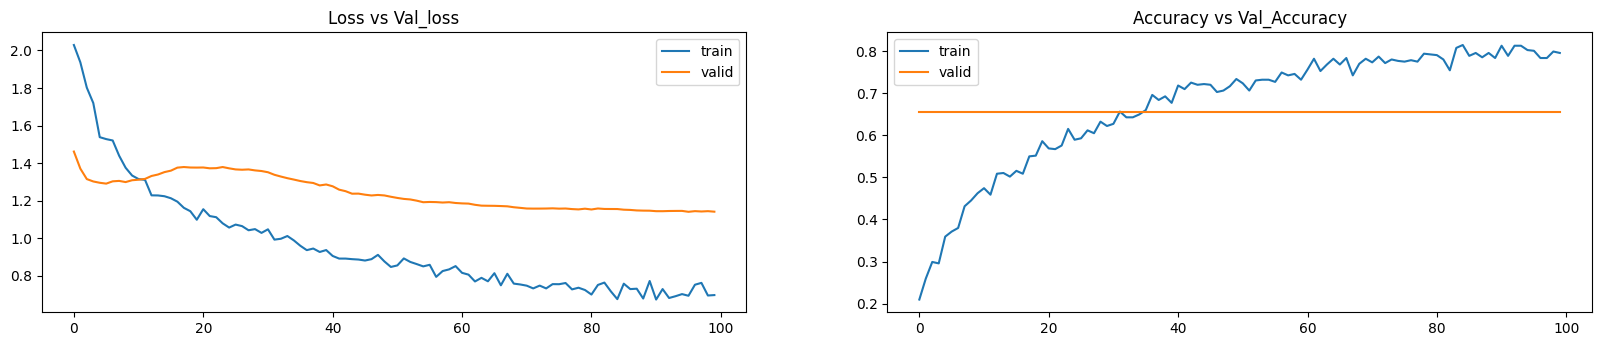

In [ ]:
#Plotting loss and accuracy curve vs epochs
plt.figure(figsize=(20,8))
plt.subplot(2,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(("train" , "valid") , loc =0)
plt.title("Loss vs Val_loss")
plt.subplot(2,2,2)
plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.legend(("train" , "valid") , loc =0)
plt.title("Accuracy vs Val_Accuracy")

3/3 [==============================] - 0s 4ms/step
Train Recall: 87.29
Test Recall: 65.48
Train Precision: 77.44
Test Precision: 42.87
Train F1: 81.74
Test F1: 51.82

Confusion matrix for training set:



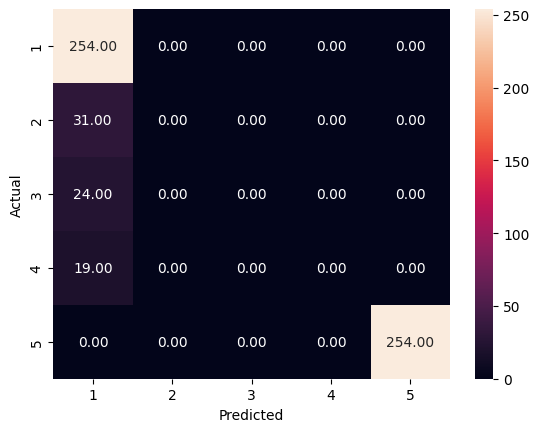


Confusion matrix for testing set:



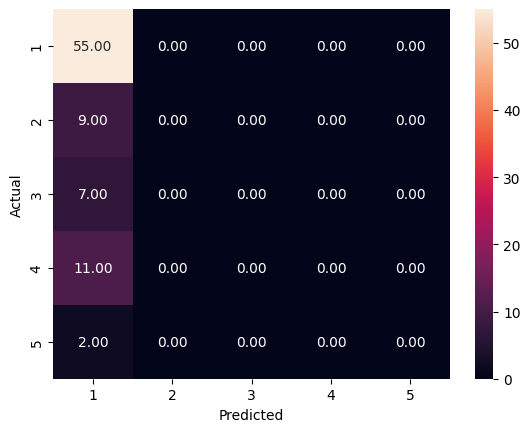

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           1       0.77      1.00      0.87       254
           2       0.00      0.00      0.00        31
           3       0.00      0.00      0.00        24
           4       0.00      0.00      0.00        19
           5       1.00      1.00      1.00       254

    accuracy                           0.87       582
   macro avg       0.35      0.40      0.37       582
weighted avg       0.77      0.87      0.82       582


Classification report for Testing set:

              precision    recall  f1-score   support

           1       0.65      1.00      0.79        55
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00         2

    accuracy                 

In [ ]:
evaluation_matrix(model3,x_train_sample,y_train_sample,x_test,y_test)

In [ ]:
model3.save('/content/drive/My Drive/model_chatbot3.h5')

In [ ]:
filename_model3 = "/content/drive/My Drive/model_chatbot3.pickle"
pickle.dump(model3, open(filename_model3, 'wb'))

Performance of the model is not improving. lets try LSTM model

# Data Preprocessing for LSTM model

Word Embeddings using Glove Vectors

In [ ]:
#Vectorization using tfidf
vec = TfidfVectorizer()

In [ ]:
#Splitting data into train and test
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.8,random_state=2)

In [ ]:
#tokenizing the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train.values)
x_train_1 = tokenizer.texts_to_sequences(x_train.values)
x_test_1 = tokenizer.texts_to_sequences(x_test.values)

In [ ]:
#pickling the tokenizer
filename = "/content/drive/My Drive/tokenizer1.pickle"
pickle.dump(tokenizer, open(filename, 'wb'))

In [ ]:
#Finding the length of vocabulary and maximum length of text

vocab = len(tokenizer.word_index) + 1
print("vocabulary size::", vocab)

maxlen = max(len(text) for text in x)
print("Maximum length:", maxlen)

vocabulary size:: 2356
Maximum length: 562


In [ ]:
#padding the data using maxlen
x_train_1 = pad_sequences(x_train_1,padding='post',maxlen=maxlen)
x_test_1 = pad_sequences(x_test_1,padding='post',maxlen=maxlen)

In [ ]:
x_train_2 = vec.fit_transform(x_train.values).toarray()
x_test_2 = vec.transform(x_test.values).toarray()

In [ ]:
#Pickling the vectorizer
filename = "/content/drive/My Drive/vec1.pickle"
pickle.dump(vec, open(filename, 'wb'))

Glove Embeddings

In [ ]:
# We need to load the built-in GloVe word embeddings
embedding_size = 200
embeddings_dictionary = dict()

glove_file = open('/content/drive/My Drive/glove.6B.200d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions

glove_file.close()

embedding_matrix = np.zeros((vocab, embedding_size))

for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector


In [ ]:
x_test_1

array([[   9,  439,  156, ...,    0,    0,    0],
       [1602,   14,  103, ...,    0,    0,    0],
       [  17, 1845,   63, ...,    0,    0,    0],
       ...,
       [ 519,   13,   80, ...,    0,    0,    0],
       [  43, 1202,   58, ...,    0,    0,    0],
       [1030,  254,    2, ...,    0,    0,    0]], dtype=int32)

# Building LSTM Model 1

In [ ]:
model_lstm = tf.keras.models.Sequential()
model_lstm.add(tf.keras.Input(shape=(maxlen,)))
model_lstm.add(tf.keras.layers.Embedding(vocab, embedding_size, weights=[embedding_matrix], trainable=False))
model_lstm.add(tf.keras.layers.LSTM(256,return_sequences = True))
model_lstm.add(tf.keras.layers.Dropout(0.2))
model_lstm.add(tf.keras.layers.LSTM(128))
model_lstm.add(tf.keras.layers.Dense(128,activation='relu'))
model_lstm.add(tf.keras.layers.Dropout(0.5))
model_lstm.add(tf.keras.layers.Dense(64,activation='relu'))
model_lstm.add(tf.keras.layers.Dropout(0.5))
model_lstm.add(tf.keras.layers.Dense(5,activation='softmax'))

In [ ]:
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 562, 200)          471200    
                                                                 
 lstm (LSTM)                 (None, 562, 256)          467968    
                                                                 
 dropout_15 (Dropout)        (None, 562, 256)          0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dense_21 (Dense)            (None, 128)               16512     
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 64)               

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15, min_delta=1e-3)
rlrp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_delta=1e-6)

# fit the keras model on the dataset
history = model_lstm.fit(x_train_1,y_train,batch_size=8,epochs=100,verbose=1,validation_data=(x_test_1,y_test),callbacks=[rlrp,callback])

Epoch 1/100
42/42 [==============================] - 80s 2s/step - loss: 1.2006 - accuracy: 0.7156 - val_loss: 0.9718 - val_accuracy: 0.7262 - lr: 0.0010
Epoch 2/100
42/42 [==============================] - 76s 2s/step - loss: 1.0322 - accuracy: 0.7305 - val_loss: 0.9486 - val_accuracy: 0.7262 - lr: 0.0010
Epoch 3/100
42/42 [==============================] - 71s 2s/step - loss: 0.9540 - accuracy: 0.7425 - val_loss: 0.9337 - val_accuracy: 0.7262 - lr: 0.0010
Epoch 4/100
42/42 [==============================] - 73s 2s/step - loss: 1.0332 - accuracy: 0.7425 - val_loss: 0.9459 - val_accuracy: 0.7262 - lr: 0.0010
Epoch 5/100
42/42 [==============================] - 72s 2s/step - loss: 0.9779 - accuracy: 0.7395 - val_loss: 0.9379 - val_accuracy: 0.7262 - lr: 0.0010
Epoch 6/100
42/42 [==============================] - 75s 2s/step - loss: 0.9793 - accuracy: 0.7425 - val_loss: 0.9365 - val_accuracy: 0.7262 - lr: 0.0010
Epoch 7/100
42/42 [==============================] - 78s 2s/step - loss: 0.9

In [ ]:
#Saving the model
model_lstm.save('/content/drive/My Drive/model_lstm.h5')

In [ ]:
filename_lstm = "/content/drive/My Drive/model_lstm.pickle"
pickle.dump(model_lstm, open(filename_lstm, 'wb'))

Text(0.5, 1.0, 'Accuracy vs Val_accuracy')

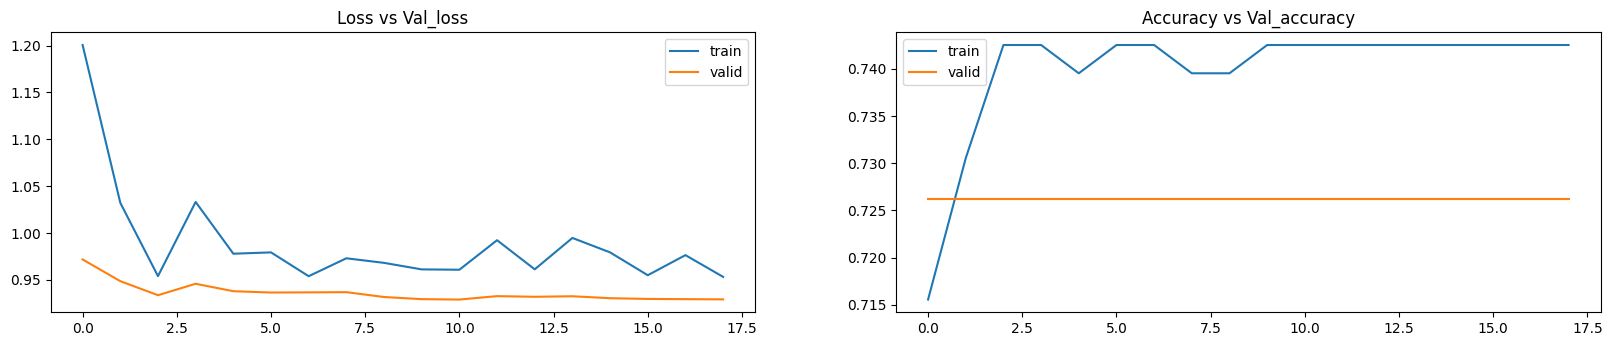

In [ ]:
#Plotting loss and accuracy curve vs epochs
plt.figure(figsize=(20,8))
plt.subplot(2,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(("train" , "valid") , loc =0)
plt.title("Loss vs Val_loss")
plt.subplot(2,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(("train" , "valid") , loc =0)
plt.title("Accuracy vs Val_accuracy")

3/3 [==============================] - 2s 718ms/step
Train Recall: 74.25
Test Recall: 72.62
Train Precision: 55.13
Test Precision: 52.74
Train F1: 63.28
Test F1: 61.1

Confusion matrix for training set:



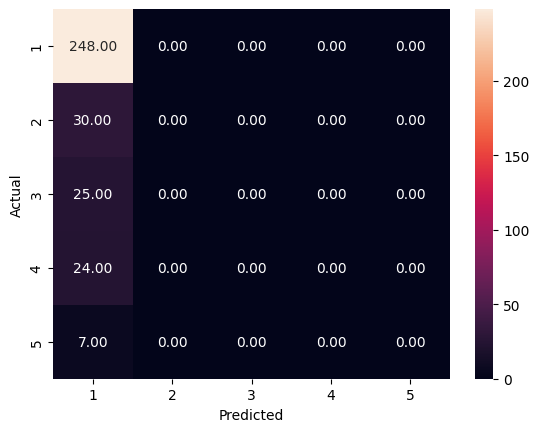


Confusion matrix for testing set:



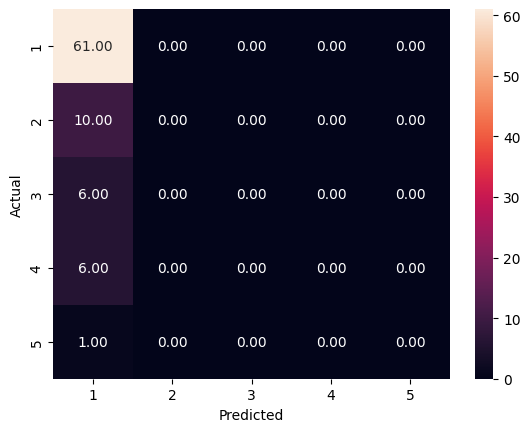

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           1       0.74      1.00      0.85       248
           2       0.00      0.00      0.00        30
           3       0.00      0.00      0.00        25
           4       0.00      0.00      0.00        24
           5       0.00      0.00      0.00         7

    accuracy                           0.74       334
   macro avg       0.15      0.20      0.17       334
weighted avg       0.55      0.74      0.63       334


Classification report for Testing set:

              precision    recall  f1-score   support

           1       0.73      1.00      0.84        61
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         1

    accuracy                 

In [ ]:
evaluation_matrix(model_lstm,x_train_1,y_train,x_test_1,y_test)

Test f1 score of the model improved to 61.1%.

# Building LSTM model 2 with Bidirectional layer

In [ ]:
# Build a LSTM Neural Network
deep_inputs = tf.keras.Input(shape=(maxlen,))
embedding_layer = tf.keras.layers.Embedding(vocab, embedding_size, weights=[embedding_matrix], trainable=False)(deep_inputs)

LSTM_Layer_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences = True))(embedding_layer)
max_pool_layer_1 = tf.keras.layers.GlobalAveragePooling1D()(LSTM_Layer_1)
drop_out_layer_1 = tf.keras.layers.Dropout(0.5, input_shape = (256,))(max_pool_layer_1)
dense_layer_1 = tf.keras.layers.Dense(128, activation = 'relu')(drop_out_layer_1)
drop_out_layer_2 = tf.keras.layers.Dropout(0.5, input_shape = (128,))(dense_layer_1)
dense_layer_2 = tf.keras.layers.Dense(64, activation = 'relu')(drop_out_layer_2)
drop_out_layer_3 = tf.keras.layers.Dropout(0.5, input_shape = (64,))(dense_layer_2)

dense_layer_3 = tf.keras.layers.Dense(32, activation = 'relu')(drop_out_layer_3)
drop_out_layer_4 = tf.keras.layers.Dropout(0.5, input_shape = (32,))(dense_layer_3)

dense_layer_4 = tf.keras.layers.Dense(10, activation = 'relu')(drop_out_layer_4)
drop_out_layer_5 = tf.keras.layers.Dropout(0.5, input_shape = (10,))(dense_layer_4)

dense_layer_5 = tf.keras.layers.Dense(5, activation='softmax')(drop_out_layer_5)

model_lstm1 = tf.keras.Model(inputs=deep_inputs, outputs=dense_layer_5)

model_lstm1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7, min_delta=1e-6)
rlrp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.125, patience=5, min_delta=1e-6)

# fit the keras model on the dataset
history = model_lstm1.fit(x_train_1,y_train,batch_size=8,epochs=100,verbose=1,validation_data=(x_test_1,y_test),callbacks=[rlrp,callback])

Epoch 1/100
42/42 [==============================] - 45s 958ms/step - loss: 1.4861 - accuracy: 0.5120 - val_loss: 1.3139 - val_accuracy: 0.7262 - lr: 0.0010
Epoch 2/100
42/42 [==============================] - 36s 862ms/step - loss: 1.2831 - accuracy: 0.6407 - val_loss: 1.1244 - val_accuracy: 0.7262 - lr: 0.0010
Epoch 3/100
42/42 [==============================] - 37s 871ms/step - loss: 1.2227 - accuracy: 0.7006 - val_loss: 1.0398 - val_accuracy: 0.7262 - lr: 0.0010
Epoch 4/100
42/42 [==============================] - 38s 899ms/step - loss: 1.1312 - accuracy: 0.7096 - val_loss: 1.0122 - val_accuracy: 0.7262 - lr: 0.0010
Epoch 5/100
42/42 [==============================] - 39s 932ms/step - loss: 1.1165 - accuracy: 0.7275 - val_loss: 0.9454 - val_accuracy: 0.7262 - lr: 0.0010
Epoch 6/100
42/42 [==============================] - 36s 853ms/step - loss: 1.1035 - accuracy: 0.7395 - val_loss: 0.9794 - val_accuracy: 0.7262 - lr: 0.0010
Epoch 7/100
42/42 [==============================] - 37s 8

Text(0.5, 1.0, 'Accuracy vs Val_accuracy')

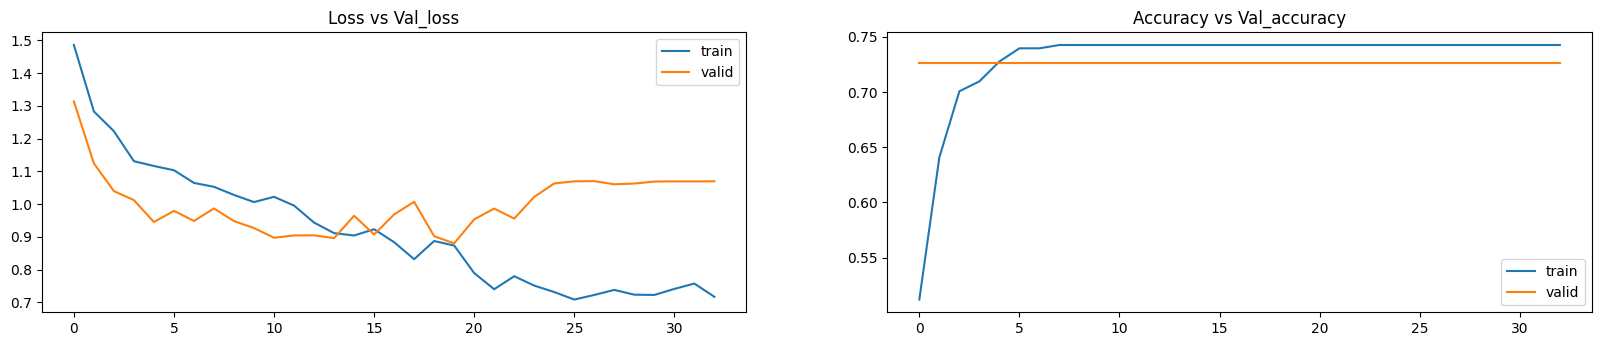

In [ ]:
#Plotting loss and accuracy curve vs epochs
plt.figure(figsize=(20,8))
plt.subplot(2,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(("train" , "valid") , loc =0)
plt.title("Loss vs Val_loss")
plt.subplot(2,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(("train" , "valid") , loc =0)
plt.title("Accuracy vs Val_accuracy")

3/3 [==============================] - 1s 426ms/step
Train Recall: 74.25
Test Recall: 72.62
Train Precision: 55.13
Test Precision: 52.74
Train F1: 63.28
Test F1: 61.1

Confusion matrix for training set:



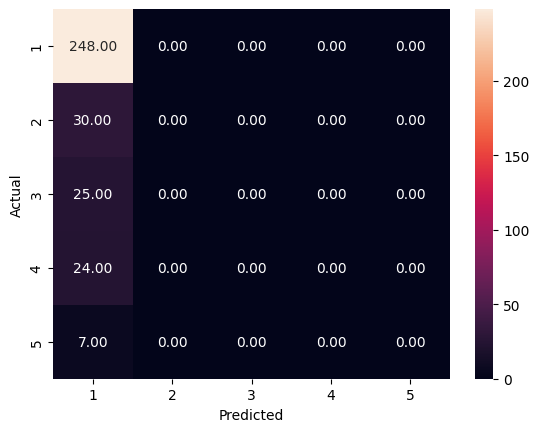


Confusion matrix for testing set:



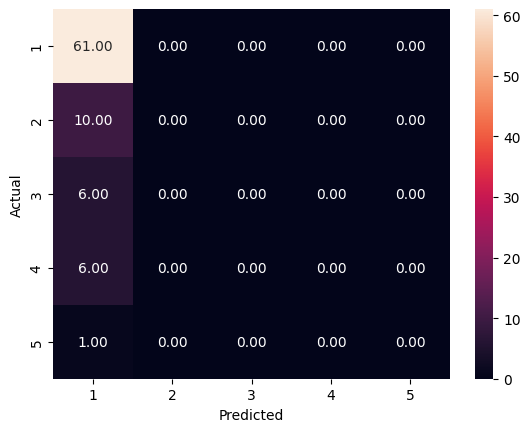

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           1       0.74      1.00      0.85       248
           2       0.00      0.00      0.00        30
           3       0.00      0.00      0.00        25
           4       0.00      0.00      0.00        24
           5       0.00      0.00      0.00         7

    accuracy                           0.74       334
   macro avg       0.15      0.20      0.17       334
weighted avg       0.55      0.74      0.63       334


Classification report for Testing set:

              precision    recall  f1-score   support

           1       0.73      1.00      0.84        61
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         1

    accuracy                 

In [ ]:
evaluation_matrix(model_lstm1,x_train_1,y_train,x_test_1,y_test)

In [ ]:
#Saving the model
model_lstm1.save('/content/drive/My Drive/model_lstm1.h5')

In [ ]:
filename_lstm1 = "/content/drive/My Drive/model_lstm1.pickle"
pickle.dump(model_lstm1, open(filename_lstm1, 'wb'))

# Building LSTM model 3

In [ ]:
# Build a LSTM Neural Network
input_1 = tf.keras.Input(shape=(maxlen,))
embedding_layer = tf.keras.layers.Embedding(vocab, embedding_size, weights=[embedding_matrix], trainable=False)(input_1)

LSTM_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences = True))(embedding_layer)
maxpool_1 = tf.keras.layers.GlobalMaxPooling1D()(LSTM_1)
dropout_1 = tf.keras.layers.Dropout(0.5, input_shape = (256,))(maxpool_1)
dense_1 = tf.keras.layers.Dense(128, activation = 'relu')(dropout_1)
dropout_2 = tf.keras.layers.Dropout(0.5, input_shape = (128,))(dense_1)
dense_2 = tf.keras.layers.Dense(64, activation = 'relu')(dropout_2)
dropout_3 = tf.keras.layers.Dropout(0.5, input_shape = (64,))(dense_2)

dense_3 = tf.keras.layers.Dense(32, activation = 'relu')(dropout_3)
dropout_4 = tf.keras.layers.Dropout(0.5, input_shape = (32,))(dense_3)

dense_4 = tf.keras.layers.Dense(10, activation = 'relu')(dropout_4)
dropout_5 = tf.keras.layers.Dropout(0.5, input_shape = (32,))(dense_4)

input_2 = tf.keras.Input(shape=(x_train_2.shape[1],))
dense_5 = tf.keras.layers.Dense(10, input_dim=x_train_2.shape[1], activation='relu', kernel_initializer='he_uniform',
                      kernel_constraint=unit_norm())(input_2)
dropout_6 = tf.keras.layers.Dropout(0.2)(dense_5)
batchnorm_1  = tf.keras.layers.BatchNormalization()(dropout_6)
dense_6 = tf.keras.layers.Dense(10, activation='relu', kernel_initializer='he_uniform',
                            kernel_constraint=unit_norm())(batchnorm_1)
dropout_7 = tf.keras.layers.Dropout(0.5)(dense_6)
batchnorm_2 = tf.keras.layers.BatchNormalization()(dropout_7)

concat_layer = tf.keras.layers.Concatenate()([dropout_5, batchnorm_2])
dense_7 = tf.keras.layers.Dense(10, activation='relu')(concat_layer)
output = tf.keras.layers.Dense(5, activation='softmax')(dense_7)
model_lstm2 = tf.keras.models.Model(inputs=[input_1, input_2], outputs=output)

model_lstm2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 562)]                0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 562, 200)             471200    ['input_3[0][0]']             
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 562, 256)             336896    ['embedding_2[0][0]']         
 onal)                                                                                            
                                                                                                  
 global_max_pooling1d (Glob  (None, 256)                  0         ['bidirectional_1[0][0]'

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15, min_delta=1e-6)
rlrp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.125, patience=5, min_delta=1e-6)

# fit the keras model on the dataset
history = model_lstm2.fit([x_train_1,x_train_2],y_train,batch_size=8,epochs=100,verbose=1,validation_data=([x_test_1,x_test_2],y_test),callbacks=[rlrp,callback])

Epoch 1/100
42/42 [==============================] - 44s 913ms/step - loss: 1.2599 - accuracy: 0.4970 - val_loss: 1.2034 - val_accuracy: 0.7262 - lr: 0.0010
Epoch 2/100
42/42 [==============================] - 39s 931ms/step - loss: 1.1370 - accuracy: 0.6737 - val_loss: 1.2872 - val_accuracy: 0.7262 - lr: 0.0010
Epoch 3/100
42/42 [==============================] - 38s 917ms/step - loss: 1.1710 - accuracy: 0.6976 - val_loss: 1.2925 - val_accuracy: 0.7262 - lr: 0.0010
Epoch 4/100
42/42 [==============================] - 36s 857ms/step - loss: 1.0579 - accuracy: 0.7216 - val_loss: 1.1989 - val_accuracy: 0.7262 - lr: 0.0010
Epoch 5/100
42/42 [==============================] - 37s 886ms/step - loss: 1.0150 - accuracy: 0.7305 - val_loss: 1.2370 - val_accuracy: 0.7262 - lr: 0.0010
Epoch 6/100
42/42 [==============================] - 39s 940ms/step - loss: 1.0341 - accuracy: 0.7335 - val_loss: 1.1584 - val_accuracy: 0.7262 - lr: 0.0010
Epoch 7/100
42/42 [==============================] - 39s 9

Text(0.5, 1.0, 'Accuracy vs Val_accuracy')

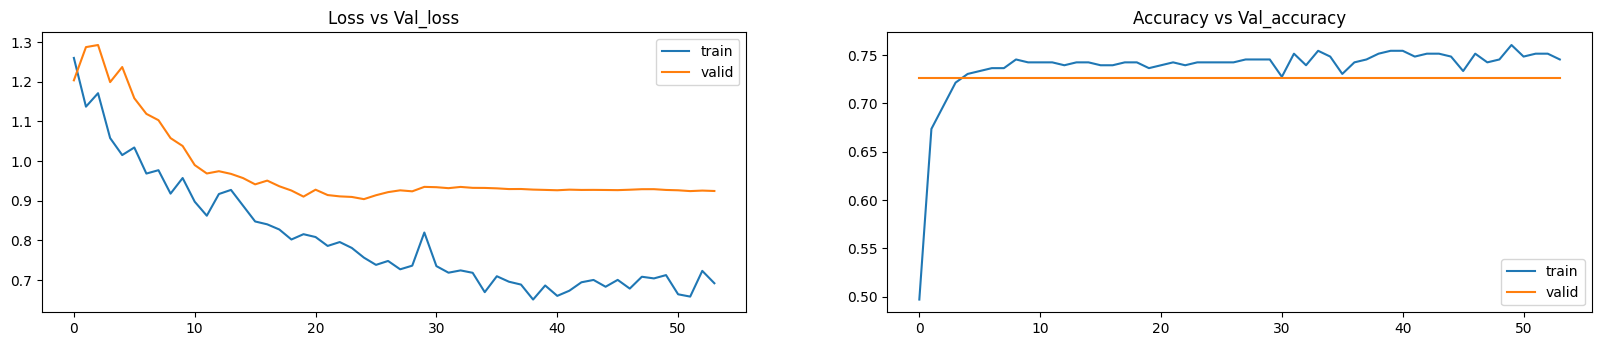

In [ ]:
#Plotting loss and accuracy curve vs epochs
plt.figure(figsize=(20,8))
plt.subplot(2,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(("train" , "valid") , loc =0)
plt.title("Loss vs Val_loss")
plt.subplot(2,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(("train" , "valid") , loc =0)
plt.title("Accuracy vs Val_accuracy")

3/3 [==============================] - 1s 438ms/step
Train Recall: 75.45
Test Recall: 72.62
Train Precision: 63.33
Test Precision: 52.74
Train F1: 65.99
Test F1: 61.1

Confusion matrix for training set:



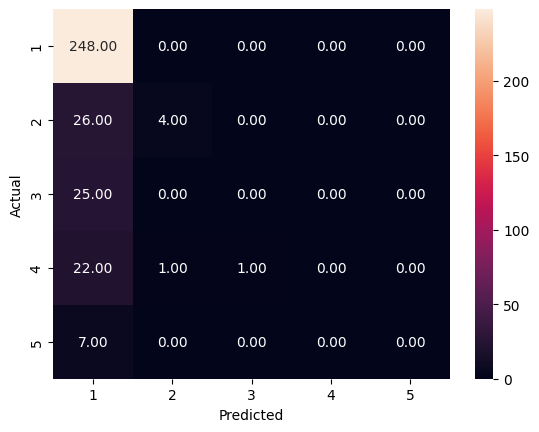


Confusion matrix for testing set:



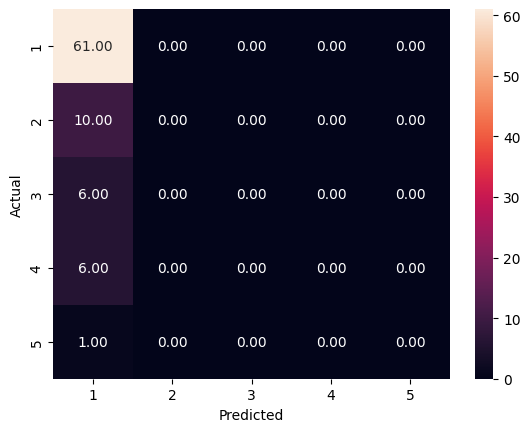

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           1       0.76      1.00      0.86       248
           2       0.80      0.13      0.23        30
           3       0.00      0.00      0.00        25
           4       0.00      0.00      0.00        24
           5       0.00      0.00      0.00         7

    accuracy                           0.75       334
   macro avg       0.31      0.23      0.22       334
weighted avg       0.63      0.75      0.66       334


Classification report for Testing set:

              precision    recall  f1-score   support

           1       0.73      1.00      0.84        61
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         1

    accuracy                 

In [ ]:
evaluation_matrix(model_lstm2,[x_train_1,x_train_2],y_train,[x_test_1,x_test_2],y_test)

In [ ]:
#Saving the model
model_lstm2.save('/content/drive/My Drive/model_lstm2.h5')

In [ ]:
filename_lstm2 = "/content/drive/My Drive/model_lstm2.pickle"
pickle.dump(model_lstm2, open(filename_lstm2, 'wb'))

#Building LSTM Model 4

In [ ]:
# Build a LSTM Neural Network
input_1 = tf.keras.Input(shape=(maxlen,))
embedding_layer = tf.keras.layers.Embedding(vocab, embedding_size, weights=[embedding_matrix], trainable=False)(input_1)

LSTM_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences = True))(embedding_layer)
maxpool_1 = tf.keras.layers.GlobalAveragePooling1D()(LSTM_1)
dropout_1 = tf.keras.layers.Dropout(0.5, input_shape = (256,))(maxpool_1)
dense_1 = tf.keras.layers.Dense(128, activation = 'relu')(dropout_1)
dropout_2 = tf.keras.layers.Dropout(0.5, input_shape = (128,))(dense_1)
dense_2 = tf.keras.layers.Dense(64, activation = 'relu')(dropout_2)
dropout_3 = tf.keras.layers.Dropout(0.5, input_shape = (64,))(dense_2)

dense_3 = tf.keras.layers.Dense(32, activation = 'relu')(dropout_3)
dropout_4 = tf.keras.layers.Dropout(0.5, input_shape = (32,))(dense_3)

dense_4 = tf.keras.layers.Dense(10, activation = 'relu')(dropout_4)
dropout_5 = tf.keras.layers.Dropout(0.5, input_shape = (32,))(dense_4)

input_2 = tf.keras.Input(shape=(x_train_2.shape[1],))
dense_5 = tf.keras.layers.Dense(20, input_dim=x_train_2.shape[1], activation='relu', kernel_initializer='he_uniform')(input_2)
dropout_6 = tf.keras.layers.Dropout(0.3)(dense_5)
batchnorm_1 = tf.keras.layers.BatchNormalization()(dropout_6)
dense_6 = tf.keras.layers.Dense(15, activation='relu', kernel_initializer='he_uniform')(batchnorm_1)
dropout_7 = tf.keras.layers.Dropout(0.3)(dense_6)
batchnorm_2 = tf.keras.layers.BatchNormalization()(dropout_7)

concat_layer = tf.keras.layers.Concatenate()([dropout_5, batchnorm_2])
dense_7 = tf.keras.layers.Dense(10, activation='relu')(concat_layer)
output = tf.keras.layers.Dense(5, activation='softmax')(dense_7)
model_lstm3 = tf.keras.models.Model(inputs=[input_1, input_2], outputs=output)

model_lstm3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 562)]                0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 562, 200)             471200    ['input_5[0][0]']             
                                                                                                  
 bidirectional_2 (Bidirecti  (None, 562, 256)             336896    ['embedding_3[0][0]']         
 onal)                                                                                            
                                                                                                  
 global_average_pooling1d_1  (None, 256)                  0         ['bidirectional_2[0][0]'

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15, min_delta=1e-6)
rlrp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_delta=1e-6)

# fit the keras model on the dataset
history = model_lstm3.fit([x_train_1,x_train_2],y_train,batch_size=6,epochs=100,verbose=1,validation_data=([x_test_1,x_test_2],y_test),callbacks=[rlrp,callback])

Epoch 1/100
56/56 [==============================] - 54s 821ms/step - loss: 1.4786 - accuracy: 0.4072 - val_loss: 1.0327 - val_accuracy: 0.7262 - lr: 0.0010
Epoch 2/100
56/56 [==============================] - 48s 852ms/step - loss: 1.1751 - accuracy: 0.6437 - val_loss: 1.1999 - val_accuracy: 0.7262 - lr: 0.0010
Epoch 3/100
56/56 [==============================] - 46s 833ms/step - loss: 1.1119 - accuracy: 0.6766 - val_loss: 1.0808 - val_accuracy: 0.7262 - lr: 0.0010
Epoch 4/100
56/56 [==============================] - 45s 801ms/step - loss: 1.0108 - accuracy: 0.7096 - val_loss: 1.0545 - val_accuracy: 0.7262 - lr: 0.0010
Epoch 5/100
56/56 [==============================] - 48s 861ms/step - loss: 0.9811 - accuracy: 0.7305 - val_loss: 0.9682 - val_accuracy: 0.7262 - lr: 0.0010
Epoch 6/100
56/56 [==============================] - 46s 829ms/step - loss: 0.9475 - accuracy: 0.7335 - val_loss: 0.9803 - val_accuracy: 0.7262 - lr: 0.0010
Epoch 7/100
56/56 [==============================] - 48s 8

Text(0.5, 1.0, 'Accuracy vs Val_accuracy')

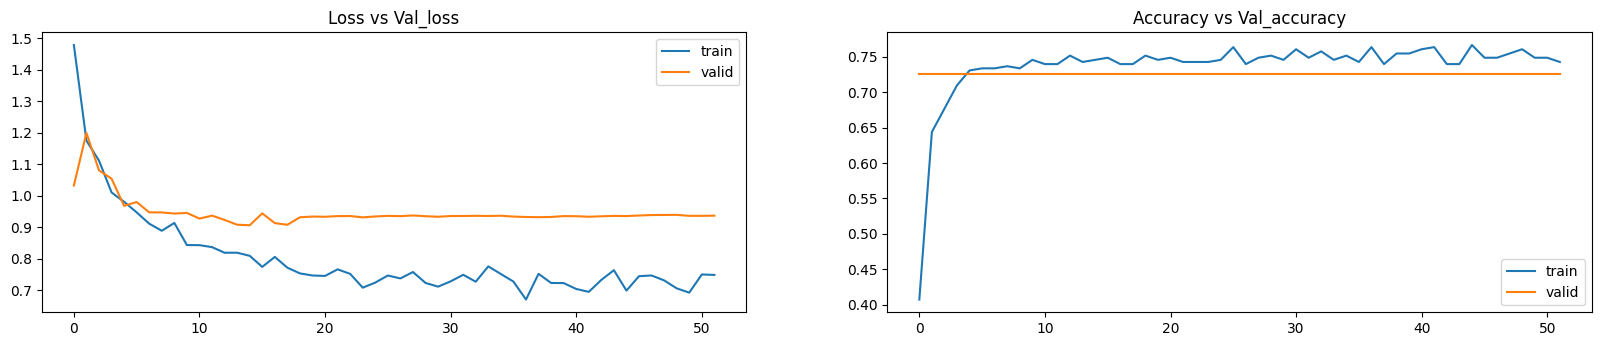

In [ ]:
#Plotting loss and accuracy curve vs epochs
plt.figure(figsize=(20,8))
plt.subplot(2,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(("train" , "valid") , loc =0)
plt.title("Loss vs Val_loss")
plt.subplot(2,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(("train" , "valid") , loc =0)
plt.title("Accuracy vs Val_accuracy")

3/3 [==============================] - 1s 426ms/step
Train Recall: 78.14
Test Recall: 72.62
Train Precision: 68.68
Test Precision: 52.74
Train F1: 71.55
Test F1: 61.1

Confusion matrix for training set:



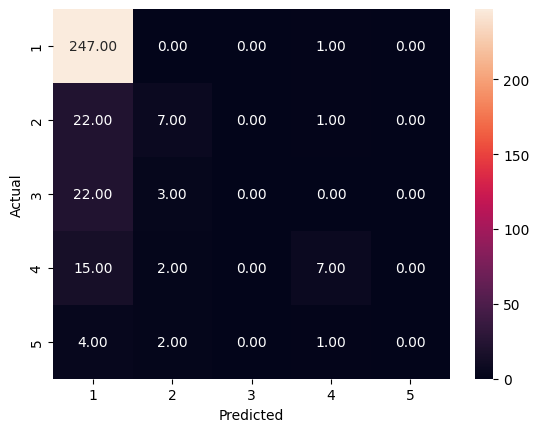


Confusion matrix for testing set:



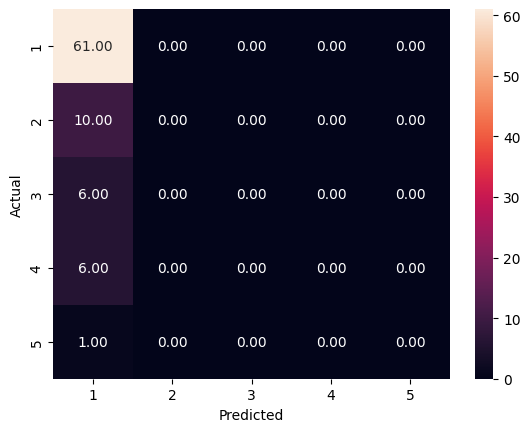

************************************************************************

Classification report for Training set:

              precision    recall  f1-score   support

           1       0.80      1.00      0.89       248
           2       0.50      0.23      0.32        30
           3       0.00      0.00      0.00        25
           4       0.70      0.29      0.41        24
           5       0.00      0.00      0.00         7

    accuracy                           0.78       334
   macro avg       0.40      0.30      0.32       334
weighted avg       0.69      0.78      0.72       334


Classification report for Testing set:

              precision    recall  f1-score   support

           1       0.73      1.00      0.84        61
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         1

    accuracy                 

In [ ]:
evaluation_matrix(model_lstm3,[x_train_1,x_train_2],y_train,[x_test_1,x_test_2],y_test)

In [ ]:
#Saving the model
model_lstm3.save('/content/drive/My Drive/model_lstm3.h5')

In [ ]:
filename_lstm3 = "/content/drive/My Drive/model_lstm3.pickle"
pickle.dump(model_lstm3, open(filename_lstm3, 'wb'))

# Streamlit chatbot

In [ ]:
ngrok.set_auth_token('2cCznoLWD9rNBIQxjaoQYVEuaI9_7EVn3a83LcJZtueLeQjvD')

In [ ]:
%%writefile app.py

import streamlit as st
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow
import numpy as np

#!pip install unidecode
import unidecode

#!pip install wordcloud
from wordcloud import WordCloud

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#NLP preprocesing functions
def rmv_uni(sen):
  wrds = sen.split()
  new_sen = [unidecode.unidecode(w) for w in wrds]
  new_sen = ' '.join(new_sen)

  return new_sen

def rmv_schar(s):
  wrds = s.split()
  new_text = [w for w in wrds if w.isalnum()]
  new_text = ' '.join(new_text)

  return new_text

def lower_case(s):
  s = s.lower()
  return s

def rmv_stpwrds(sen):
  wrds = sen.split()
  new_text = [w for w in wrds if w not in stopwords.words('english')]
  new_text = ' '.join(new_text)

  return new_text

lemmatizer = WordNetLemmatizer()

def stem(sen):
  wrds = sen.split()
  new_text = [lemmatizer.lemmatize(w) for w in wrds]
  new_text =  ' '.join(new_text)

  return new_text

def strp(sen):
  sen = sen.strip()
  return sen



#title
st.set_page_config(page_title="Industrial Safety NLP Based Chatbot",layout="centered",page_icon="👷")

st.title("Industrial Safety NLP Based chatbot")




# loading the trained model
token = "/content/drive/My Drive/tokenizer1.pickle"
vec = "/content/drive/My Drive/vec1.pickle"
loaded_model = pickle.load(open("/content/drive/My Drive/model_lstm3.pickle",'rb'))
loaded_token = pickle.load(open(token,'rb'))
loaded_vec = pickle.load(open(vec,'rb'))


txt = st.text_area(
  "Report the Incident",
)

pred = ''
if st.button('Check Potential Accident Level'):

  txt = rmv_uni(txt)
  txt = rmv_schar(txt)
  txt = lower_case(txt)
  txt = rmv_stpwrds(txt)
  txt = stem(txt)
  txt = strp(txt)

  txt = np.array([txt],dtype='object')
  x1 = loaded_token.texts_to_sequences(txt)
  x1 = pad_sequences(x1,padding='post',maxlen=562)

  x2 = loaded_vec.transform(txt).toarray()

  prediction = loaded_model.predict([x1,x2])
  prediction = np.argmax(pred,axis=0)+1
  pred = prediction

st.success(pred)
  #st.write(txt)

Overwriting app.py


In [ ]:
def run_streamlit():
  os.system("streamlit run /content/app.py --server.port 8501")

In [ ]:
thread = Thread(target=run_streamlit)
thread.start()

In [ ]:
public_url = ngrok.connect(addr='8501', proto='http', bind_tls=True)
print("Your streamlit app is live at :", public_url)

Your streamlit app is live at : NgrokTunnel: "https://e7aa-34-75-46-156.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
ngrok.kill()

# CONCLUSION

* Out of all the model bidirectional model with two input performs better.
* The model predict the accident level with a test f1-score of 61.10%.
* Also deep learning models perform better than machine learning model.
* Finally bidirectional LSTM model with two inputs can be considered to productionalized the model and predict the accident level.
* Finally created an web application chatbot using streamlit.

# LIMITATIONS

* We have less number of observations to analyse the cause of accidents correctly and rather we should collect more number of observations to get better results.
* Lack of access to quality data.